# Generative Models

## GANs & VAE

### HW4

**Full Name: Amir Mohammad Ezzati**

**SID: 402212269**

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [2]:

from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/DL/HW4/models/"

Mounted at /content/drive


# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [3]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [4]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17528375.35it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479426.34it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 905753.22it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9106371.30it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
num_threads = 4
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mean = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
        ##########################################################


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        h = self.linear(x)
        h = F.relu(h)
        z_mean = self.linear_mean(h)
        logvar = self.linear_logvar(h)
        z_log_var = torch.exp(0.5 * logvar)
        ##########################################################

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        ##############################

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x = F.sigmoid(h)
        ########################################

        return x

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        z_mean, z_log_var = self.encoder(x)

        # reparameterizing
        eps = torch.randn_like(z_log_var).to(DEVICE)
        z = z_mean + eps * z_log_var

        image = self.decoder(z)
        ##########################################################

        return image, z_mean, z_log_var

In [8]:
def reconstruct_images(vae, images):
    images = images.view(-1, 784)
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images.view(-1, 1, 28, 28)

def plot_images(original, reconstructed, n=4):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.show()

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    """Elbo loss function."""
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + kld

def train_vae(dataloader, val_loader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim)
    model = model.to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        print(f'Epoch {epoch+1}: ')
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                x = data[0]
                x = x.view(-1, input_dim)
                x = x.to(DEVICE)

                optimizer.zero_grad()
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)
                loss.backward()

                train_loss += loss.item()
                optimizer.step()
                ###############################################

            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        with torch.no_grad():
          model.eval()
          recon_images = reconstruct_images(model, sample_images)
          plot_images(sample_images, recon_images)

          val_loss = 0
          with tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, data in pbar:
                x = data[0]
                x = x.view(-1, input_dim)
                x = x.to(DEVICE)
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)
                val_loss += loss.item()

            print('Val Loss: {:.4f}'.format(val_loss / len(val_loader.dataset)))
            val_losses.append(val_loss / len(val_loader.dataset))


        # Sample From Latent Space
        if epoch % 10 == 0:
            with torch.no_grad():
                x = torch.randn(8, latent_dim).to(DEVICE)
                samples = model.decoder(x).cpu()
                samples = samples.view(8, 1, 28, 28)
                grid_img = torchvision.utils.make_grid(samples, nrow=4, padding=2, normalize=True)
                plt.figure(figsize=(15, 15))
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.axis('off')
                plt.show()

    return model, val_losses

Epoch 1: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 245.2696


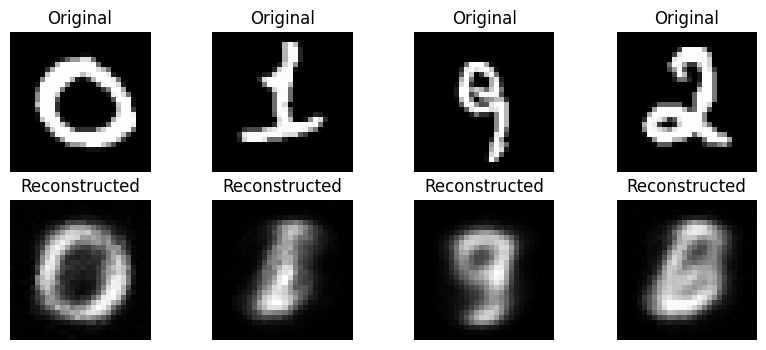

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 180.3757


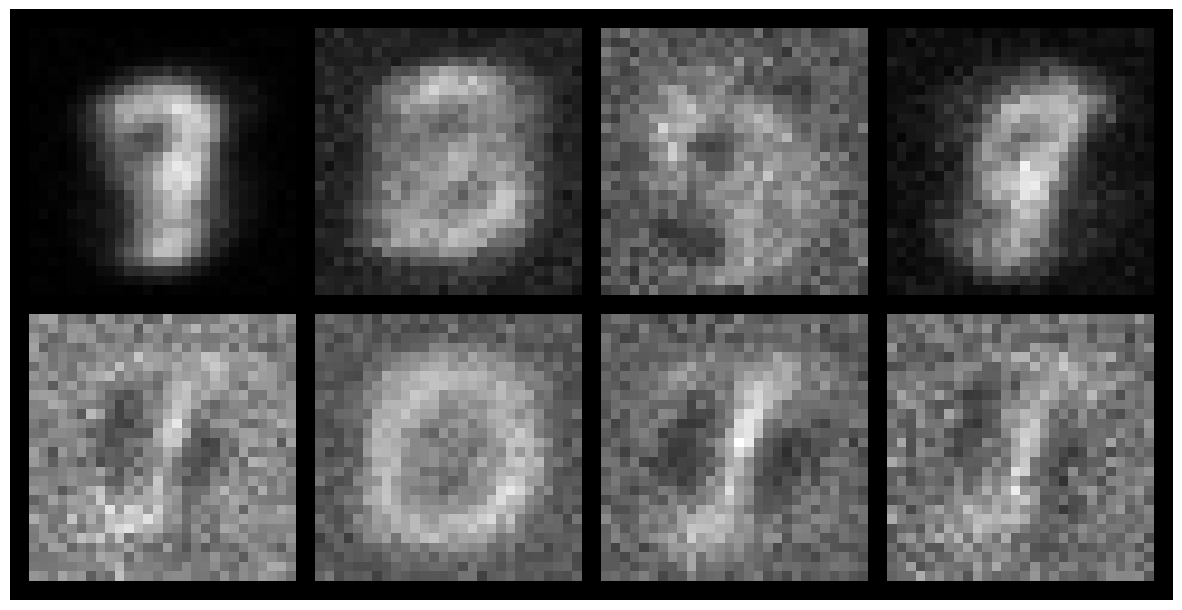

Epoch 2: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 158.4962


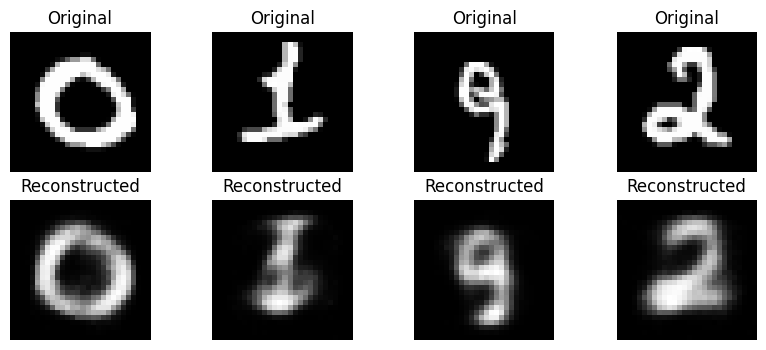

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 144.1111
Epoch 3: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 136.1710


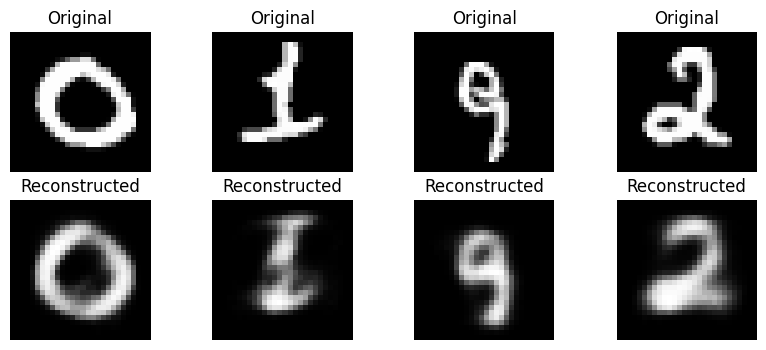

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 130.6607
Epoch 4: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 126.4850


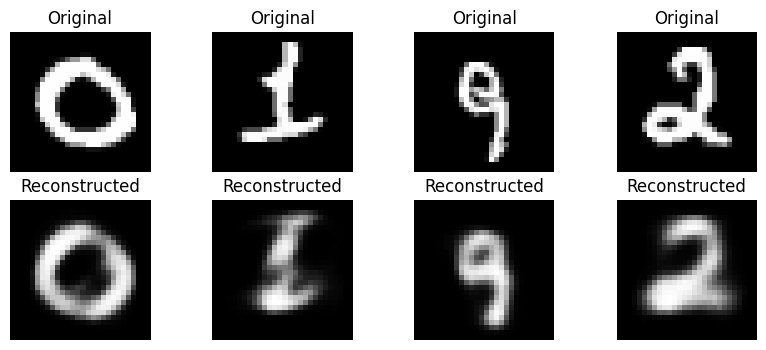

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 123.8543
Epoch 5: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 121.1439


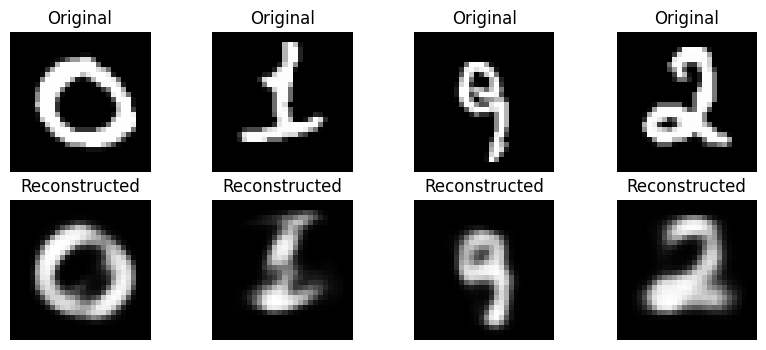

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.5671
Epoch 6: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 117.4345


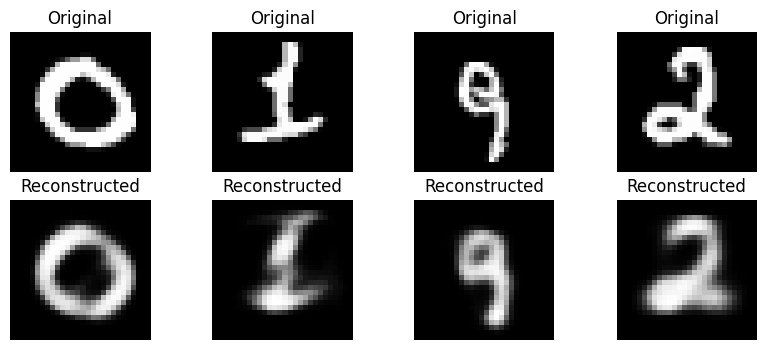

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.3366
Epoch 7: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.5570


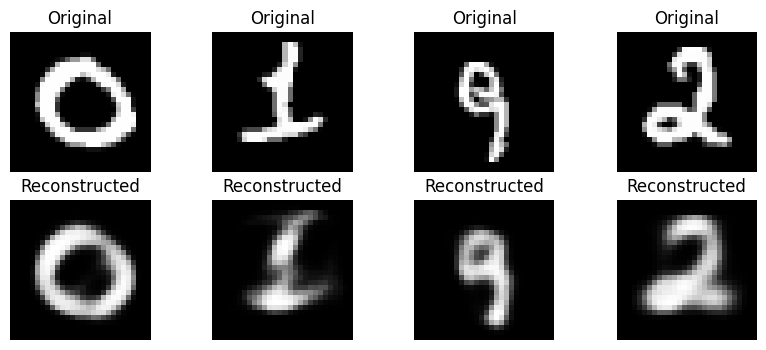

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.8218
Epoch 8: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.2153


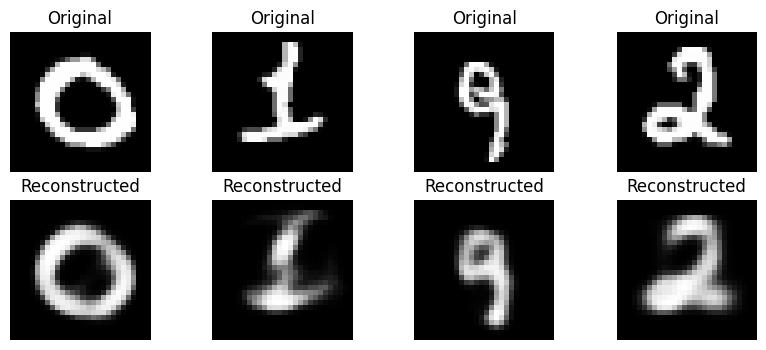

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.7033
Epoch 9: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.2582


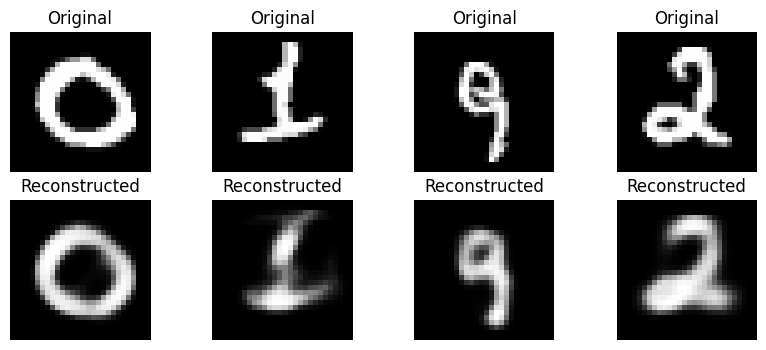

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 109.9153
Epoch 10: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 108.5843


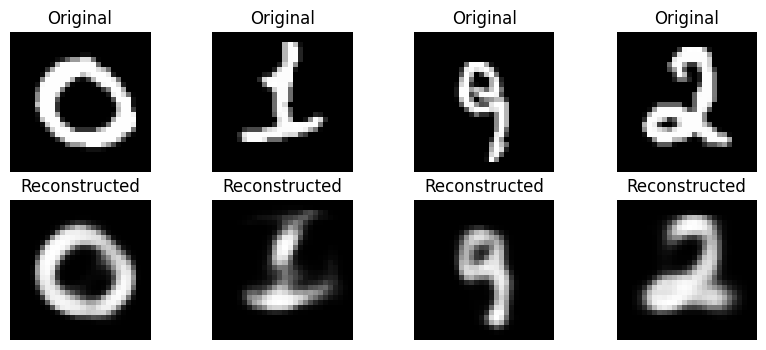

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 108.3917
Epoch 11: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 107.1381


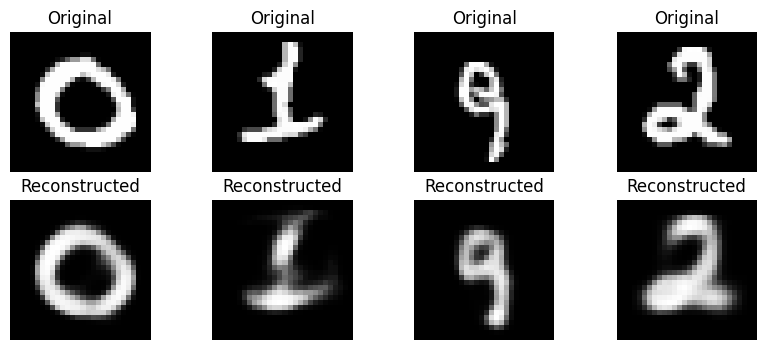

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 107.0847


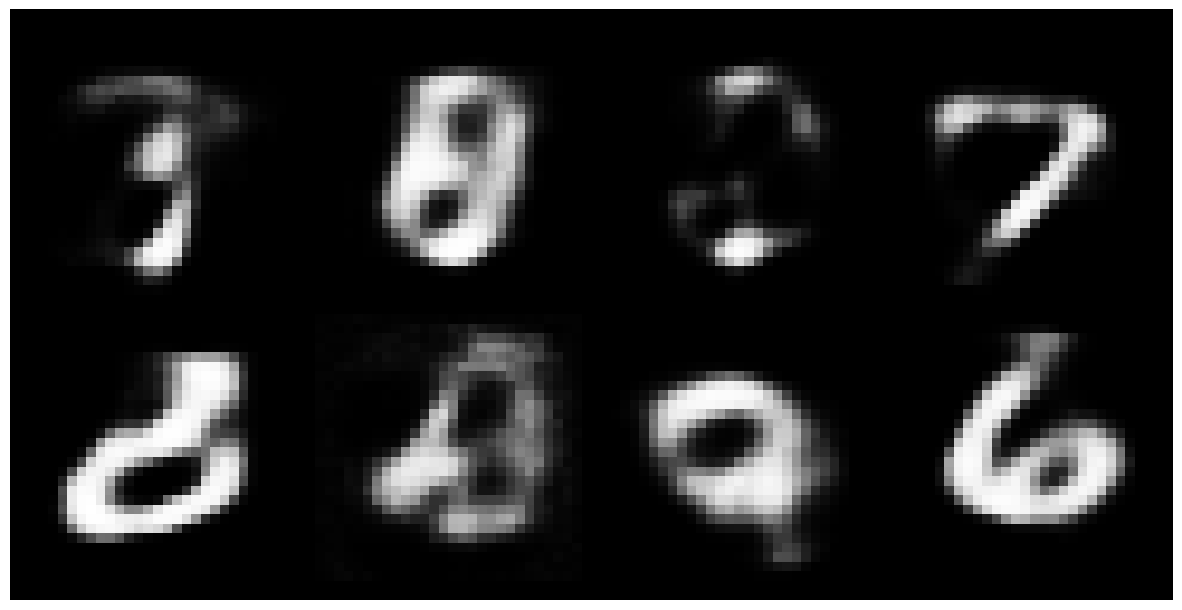

Epoch 12: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 105.8582


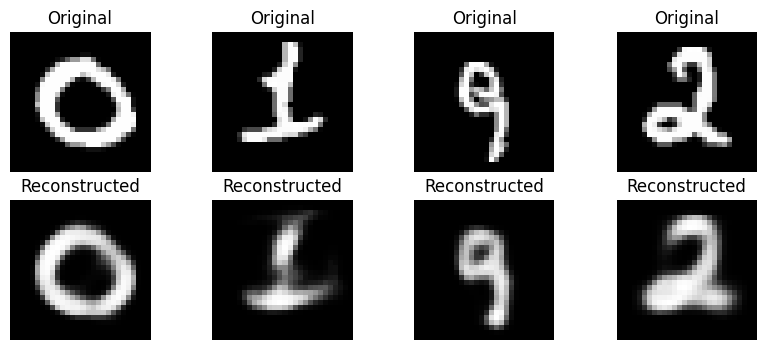

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 105.9027
Epoch 13: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 104.7231


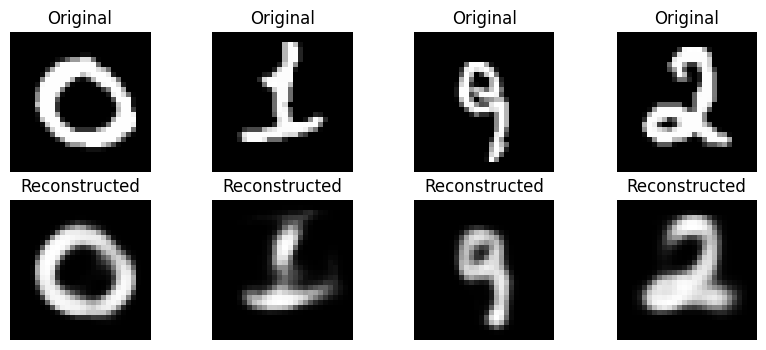

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 104.8506
Epoch 14: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 103.7097


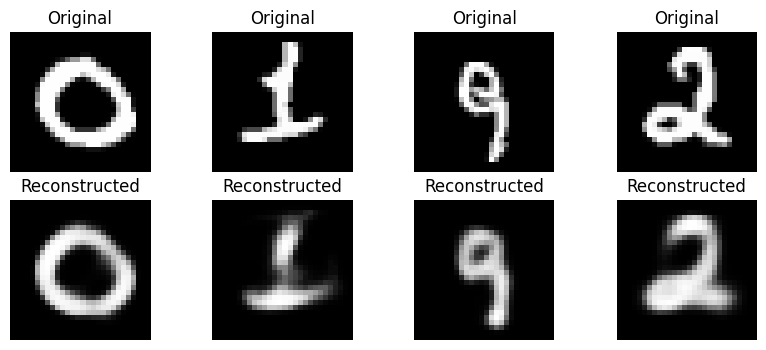

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 103.9459
Epoch 15: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 102.7952


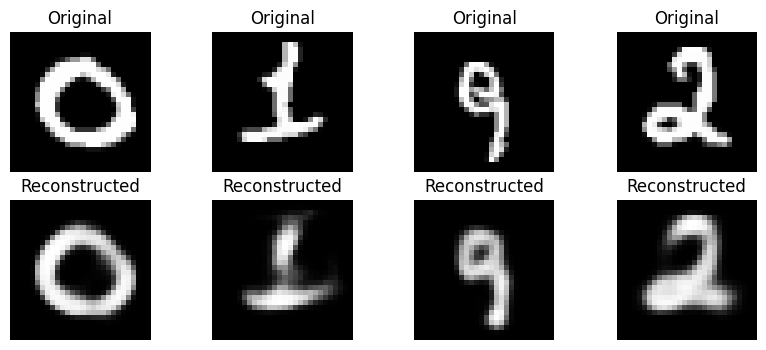

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 103.0682
Epoch 16: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 101.9713


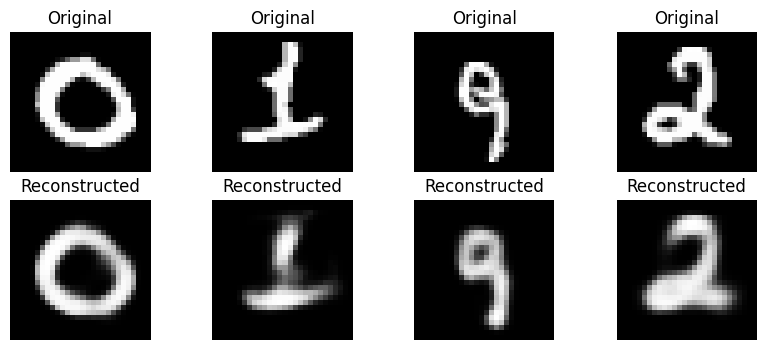

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 102.3319
Epoch 17: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 101.2234


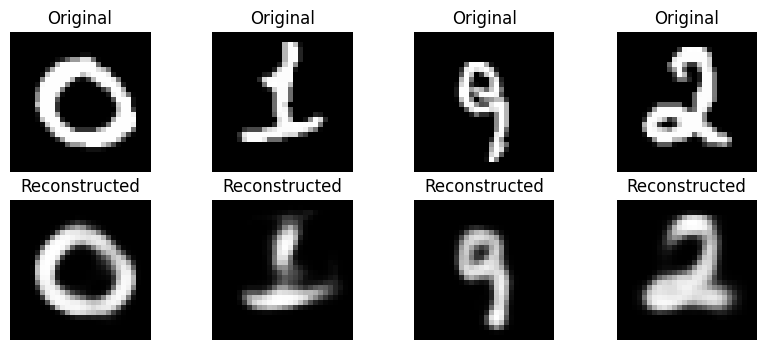

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 101.6811
Epoch 18: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 100.5479


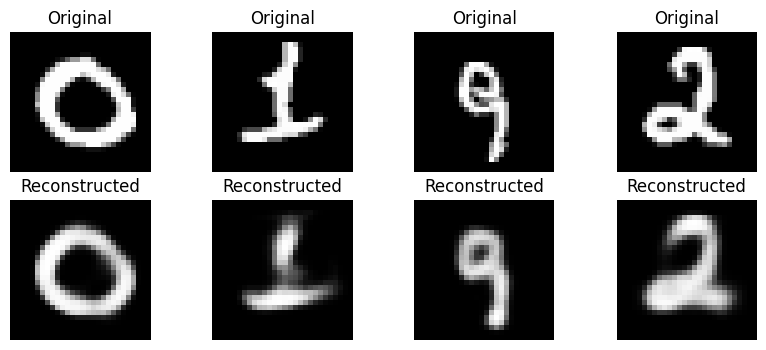

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 101.0890
Epoch 19: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 99.9239


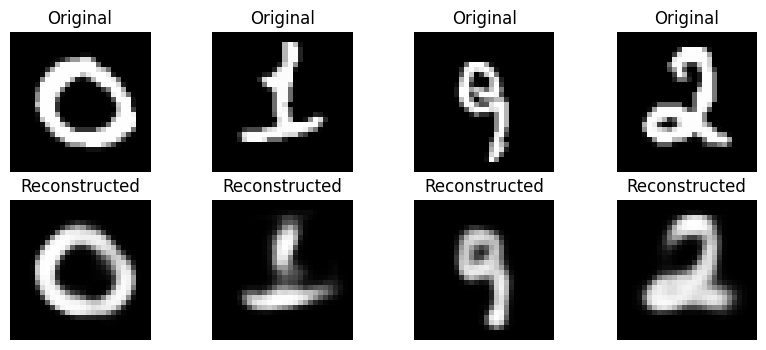

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 100.4732
Epoch 20: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 99.3485


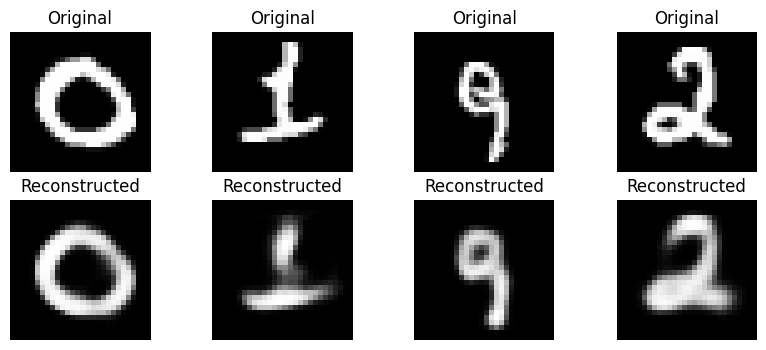

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 99.9414
Epoch 21: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 98.8238


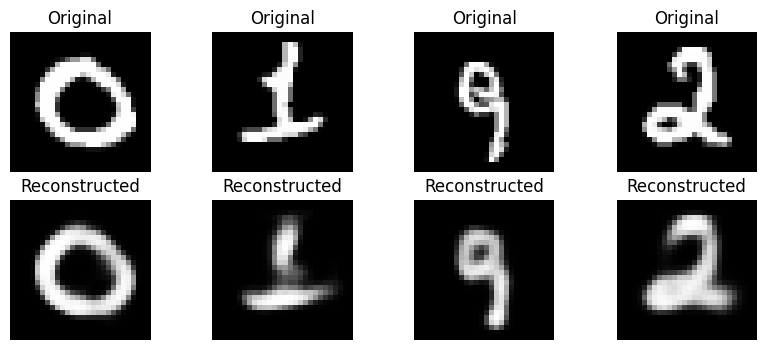

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 99.4451


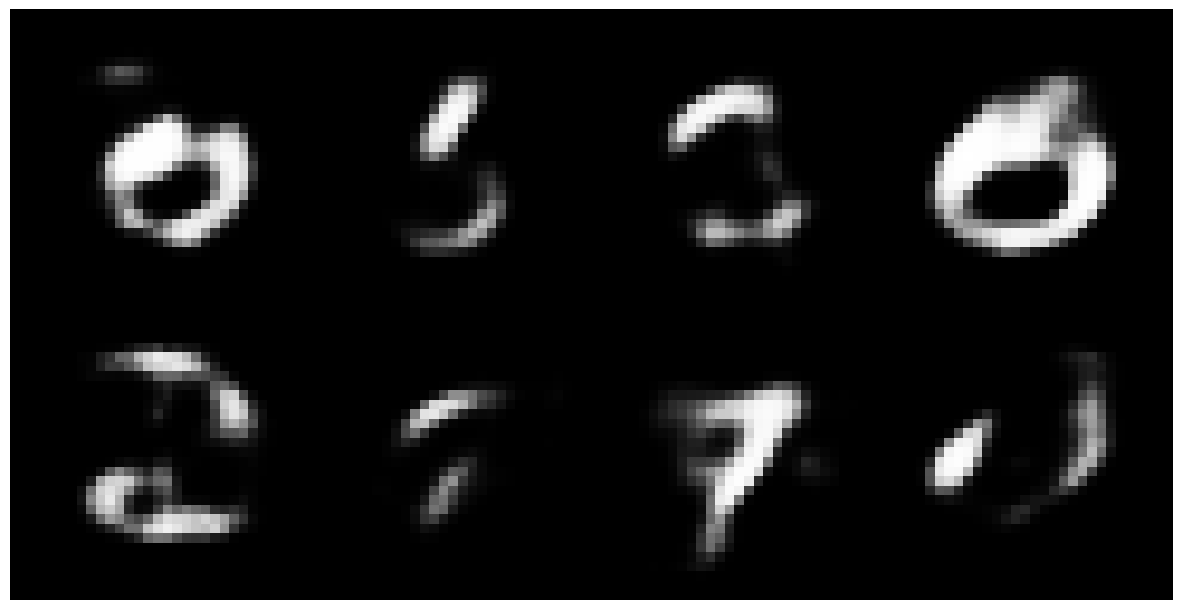

Epoch 22: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 98.3398


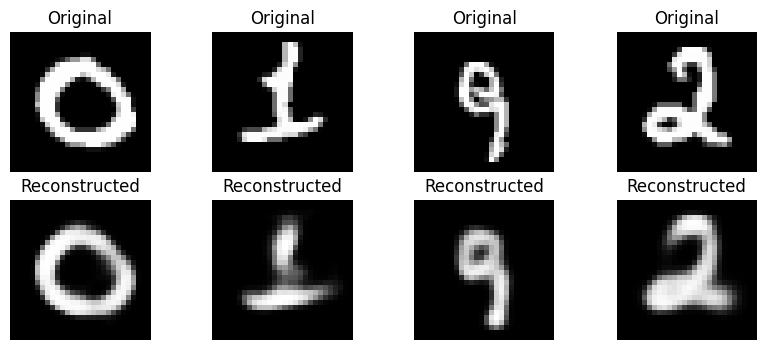

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 99.0324
Epoch 23: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 97.8806


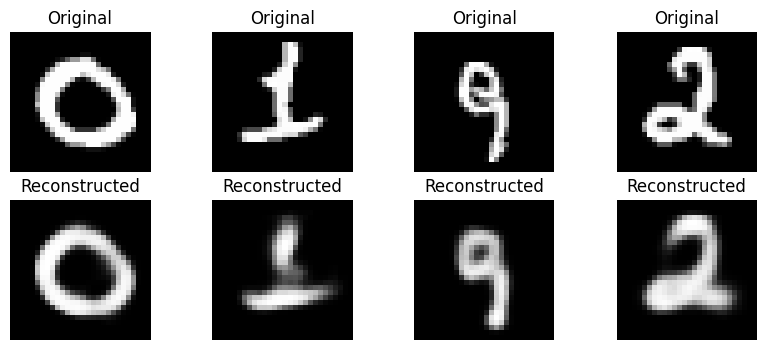

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 98.6108
Epoch 24: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 97.4629


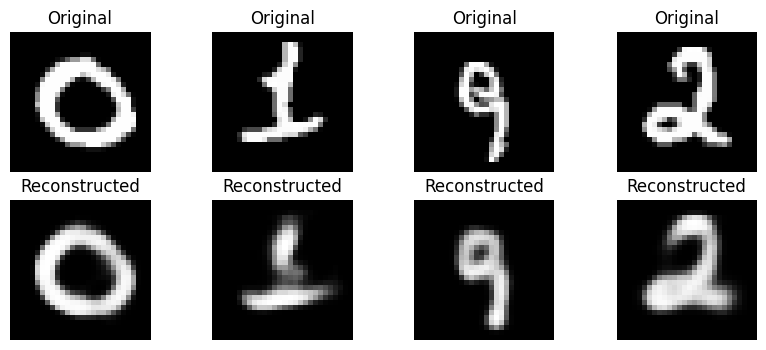

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 98.1907
Epoch 25: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 97.0601


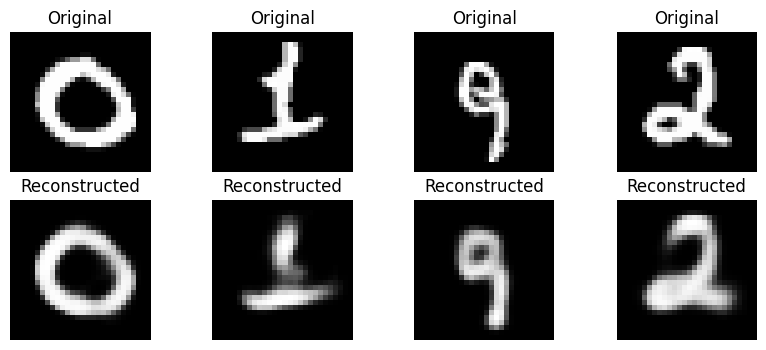

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 97.8280
Epoch 26: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 96.6974


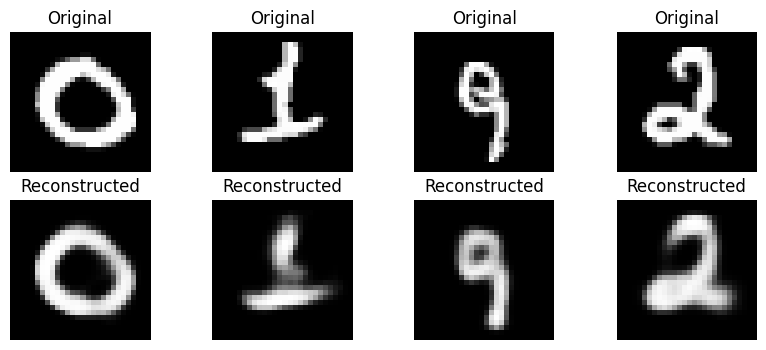

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 97.4897
Epoch 27: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 96.3428


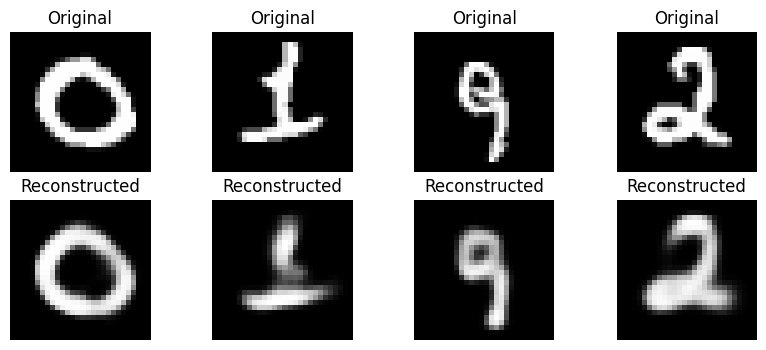

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 97.1843
Epoch 28: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 96.0134


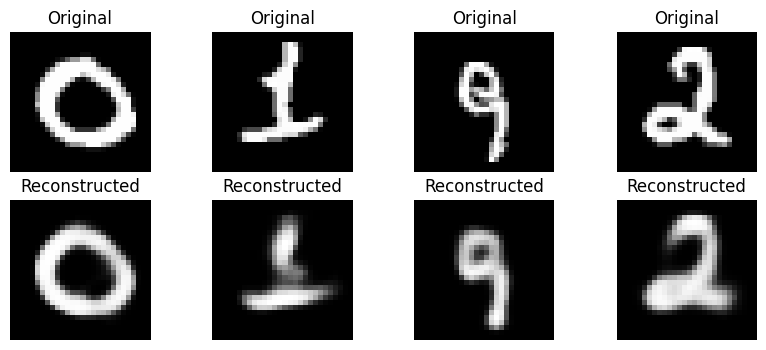

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 96.8490
Epoch 29: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 95.7050


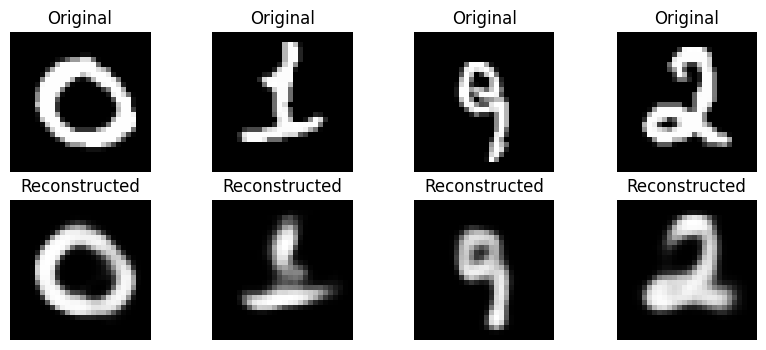

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 96.5818
Epoch 30: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 95.4009


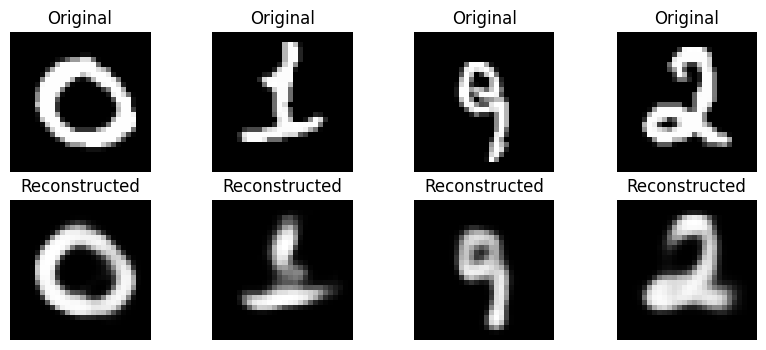

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 96.2468
Epoch 31: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 95.1218


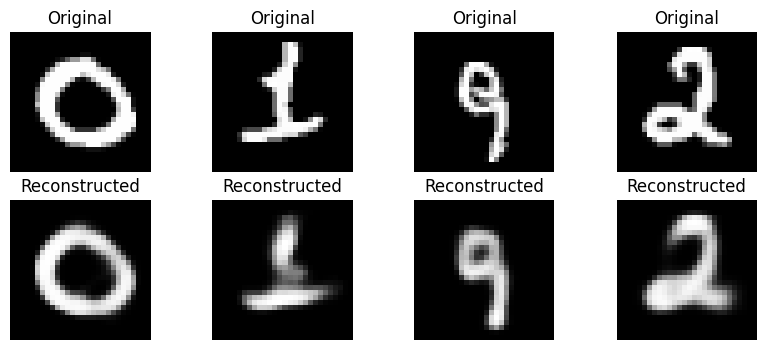

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 96.0885


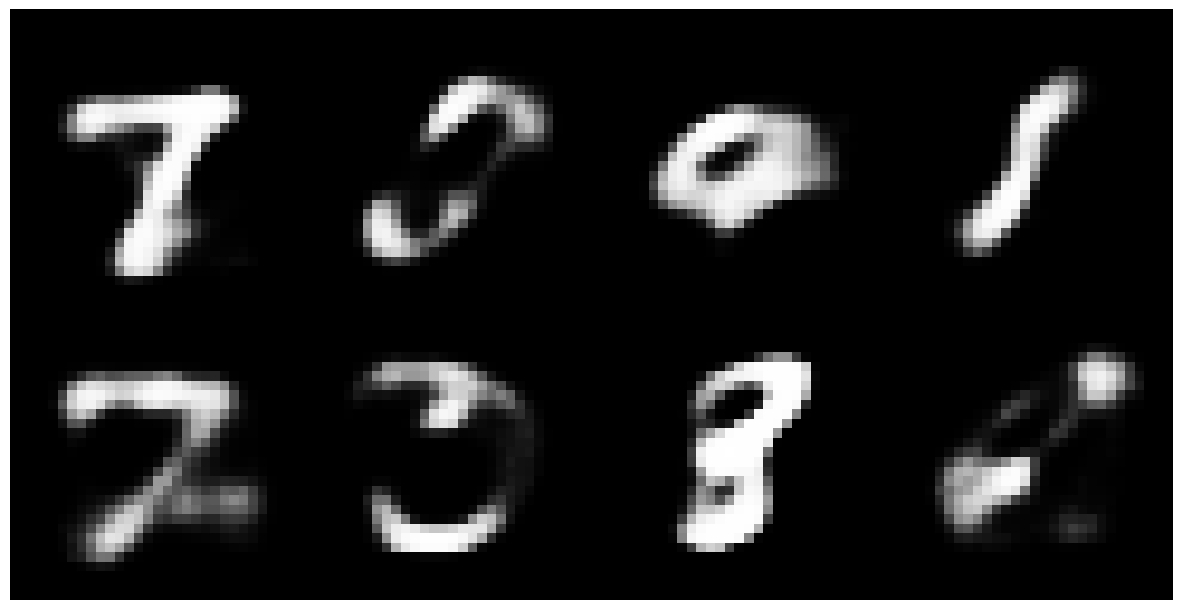

Epoch 32: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 94.8557


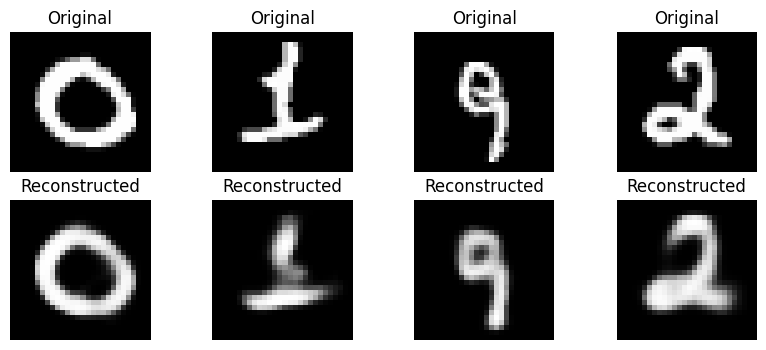

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 95.7814
Epoch 33: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 94.5985


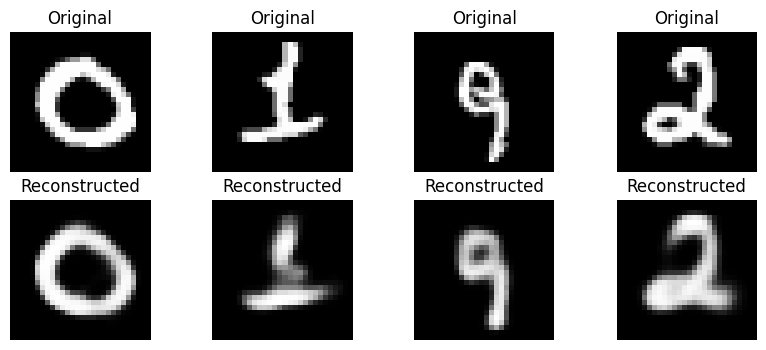

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 95.5645
Epoch 34: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 94.3556


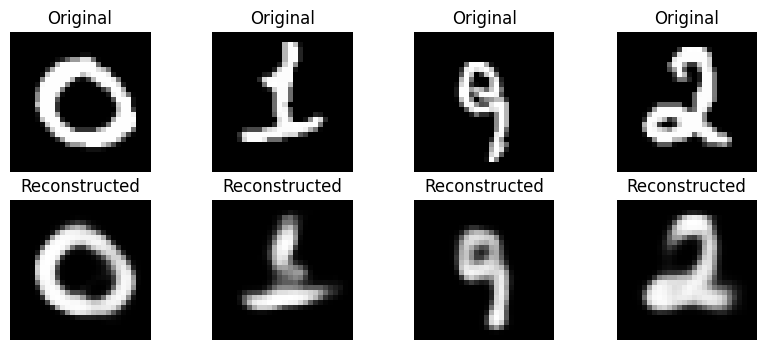

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 95.2916
Epoch 35: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 94.1278


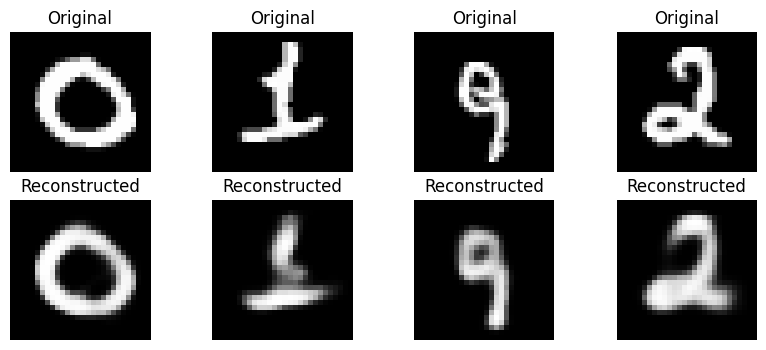

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 95.1374
Epoch 36: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 93.8967


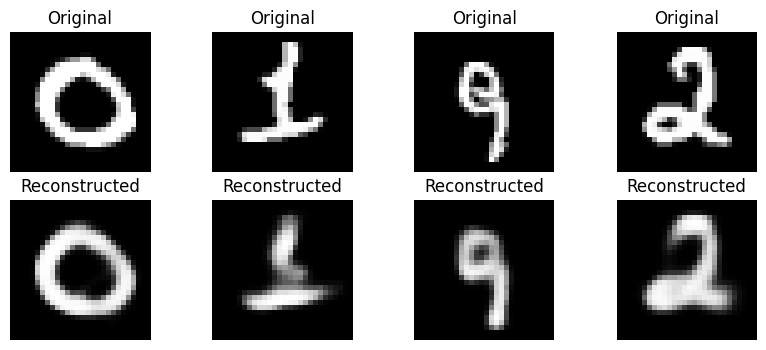

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 94.8969
Epoch 37: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 93.6890


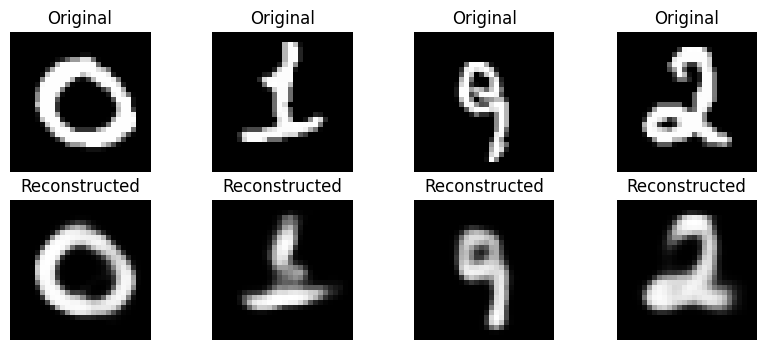

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 94.6871
Epoch 38: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 93.4738


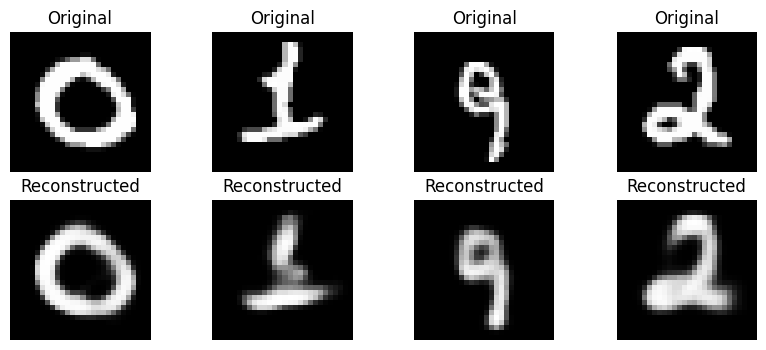

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 94.5143
Epoch 39: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 93.2776


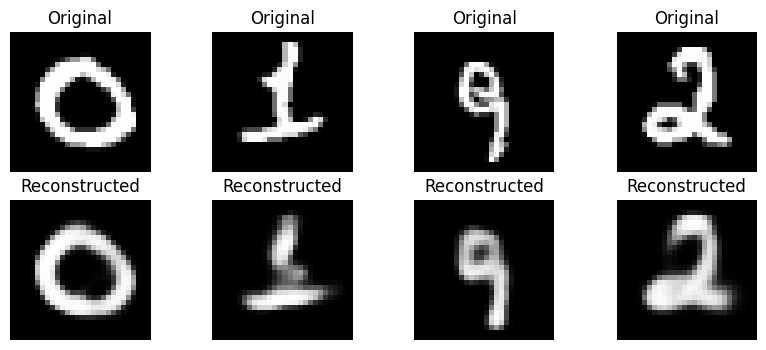

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 94.3041
Epoch 40: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 93.0907


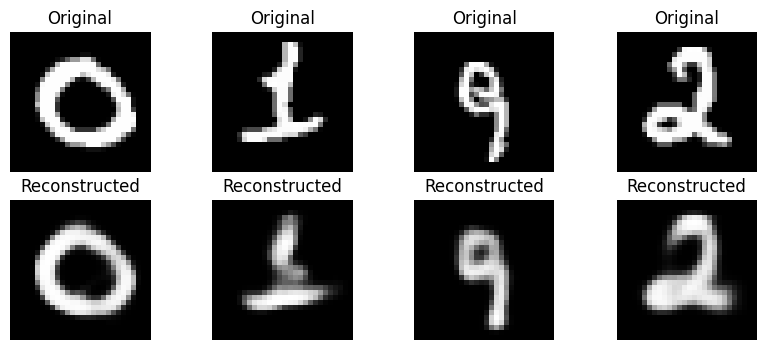

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 94.1368
Epoch 41: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 92.9076


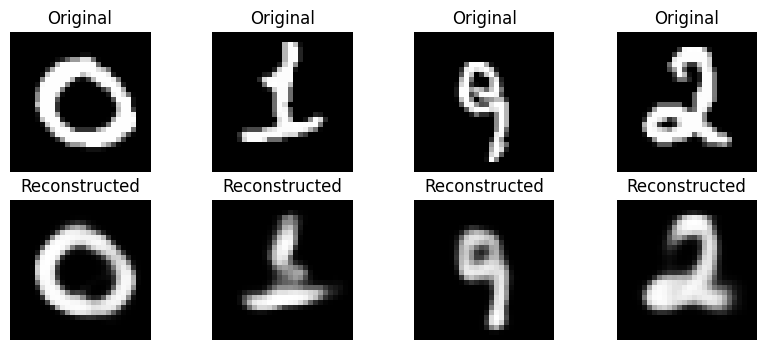

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.9645


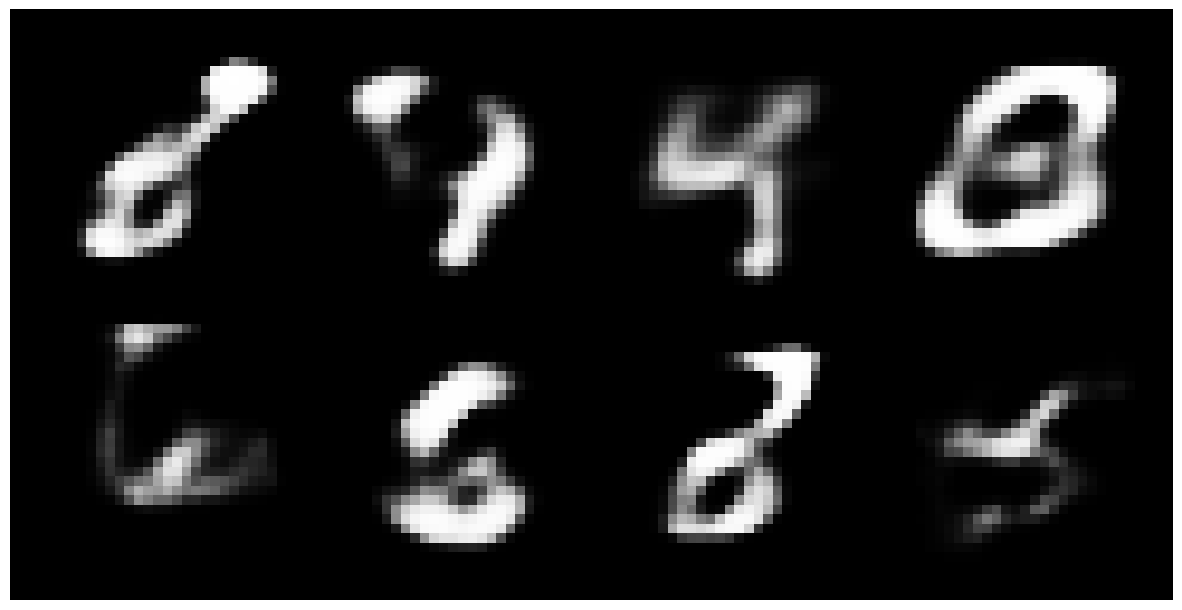

Epoch 42: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 92.7184


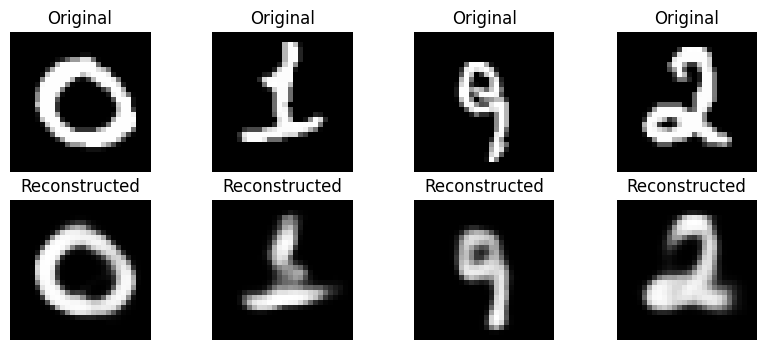

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.7973
Epoch 43: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 92.5583


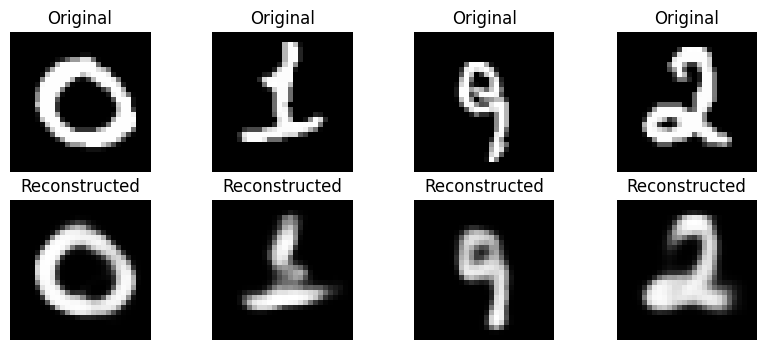

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.6898
Epoch 44: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 92.3899


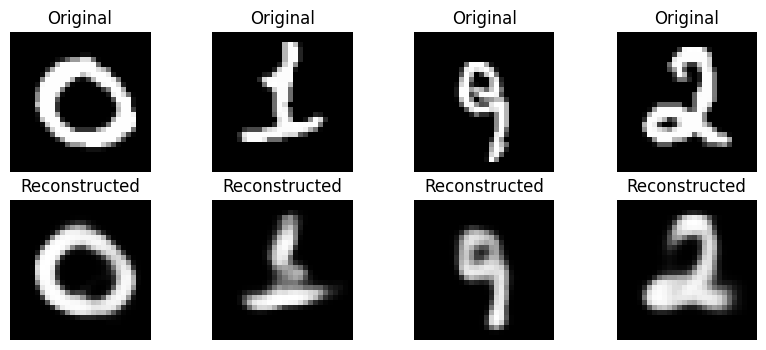

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.4760
Epoch 45: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 92.2274


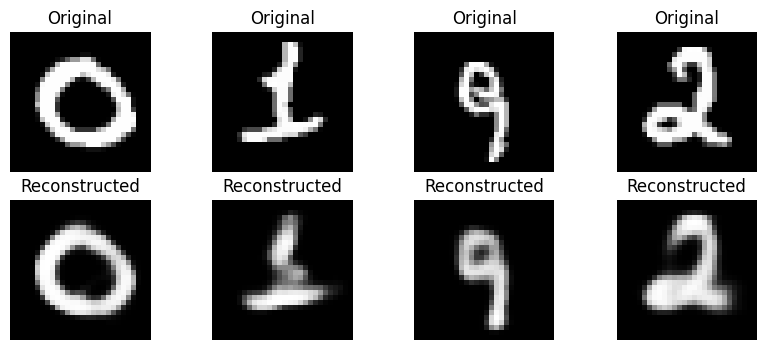

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.4176
Epoch 46: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 92.0757


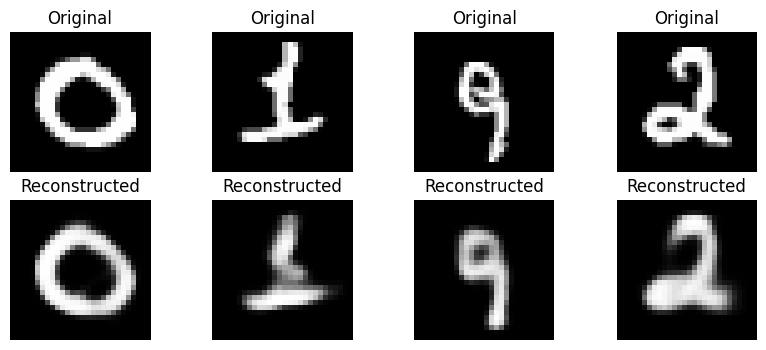

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.2390
Epoch 47: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.9259


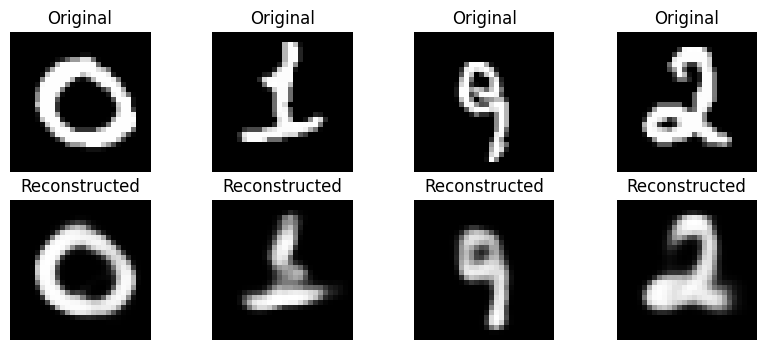

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 93.0708
Epoch 48: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.7717


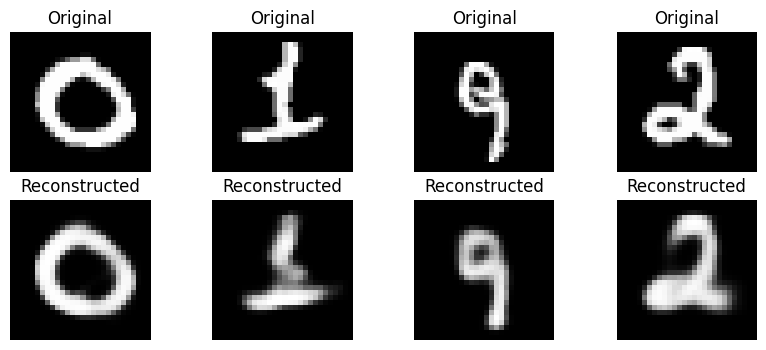

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.9066
Epoch 49: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.6316


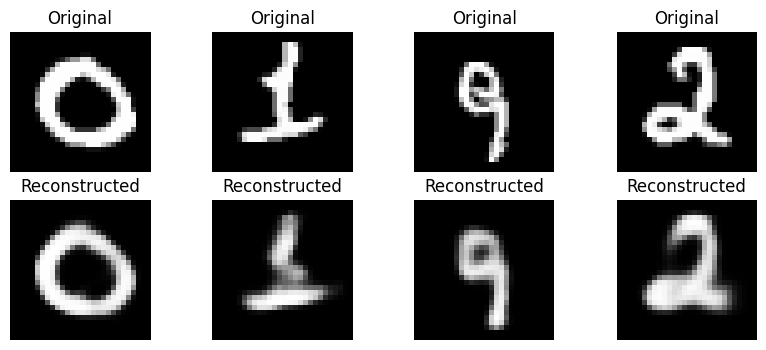

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.8661
Epoch 50: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.4951


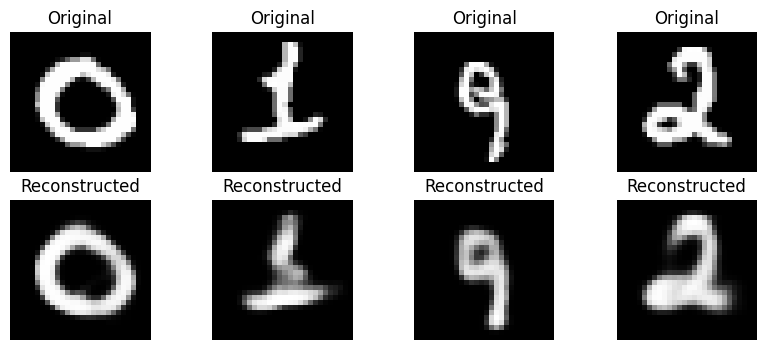

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.7040
Epoch 51: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.3589


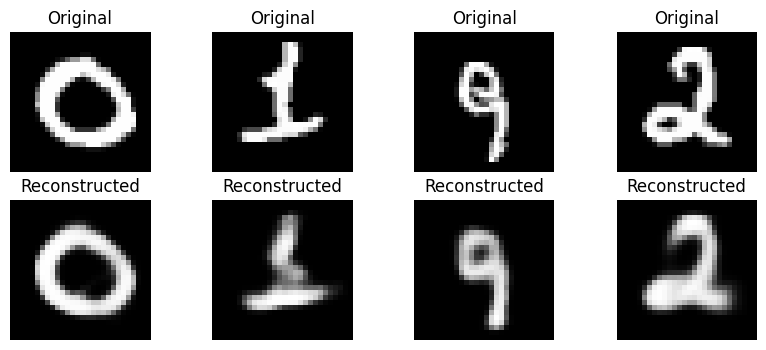

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.6314


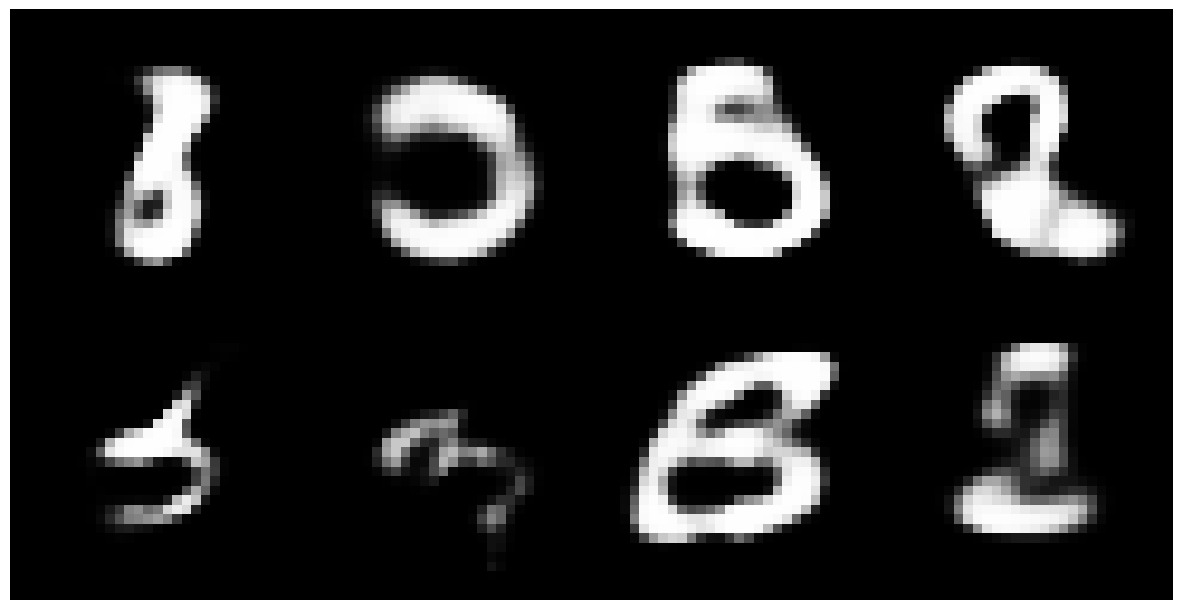

Epoch 52: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.2272


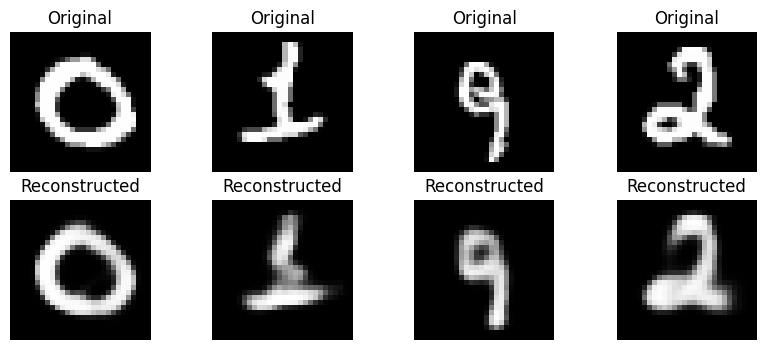

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.5523
Epoch 53: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 91.1050


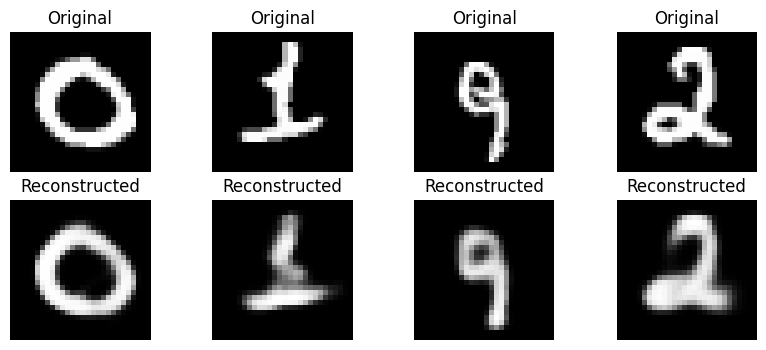

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.3268
Epoch 54: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.9687


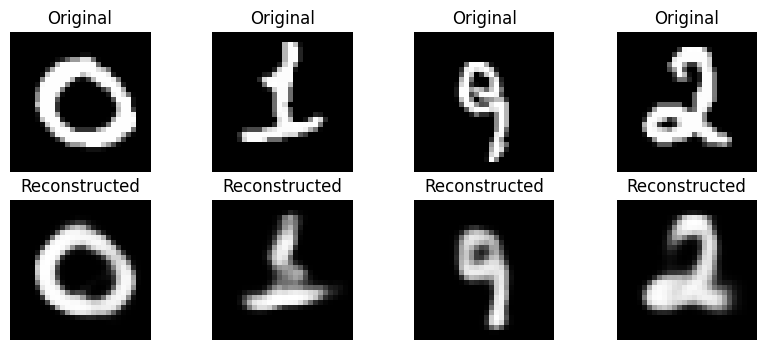

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.1812
Epoch 55: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.8596


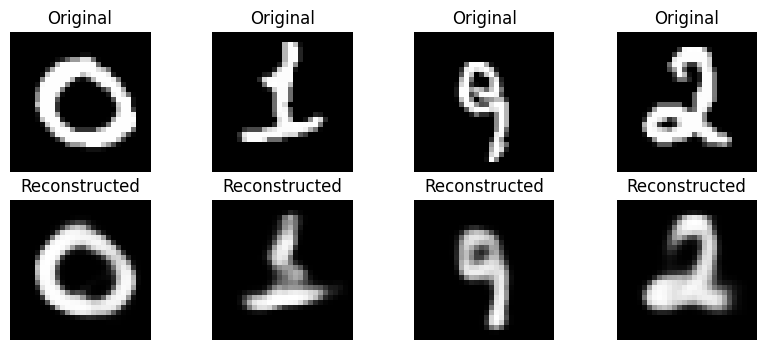

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.1189
Epoch 56: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.7390


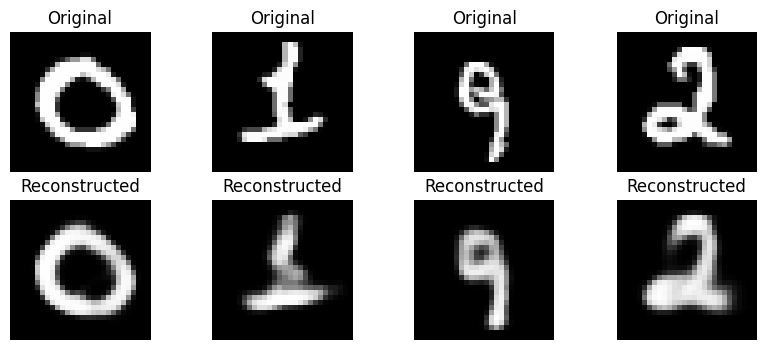

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 92.0133
Epoch 57: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.6207


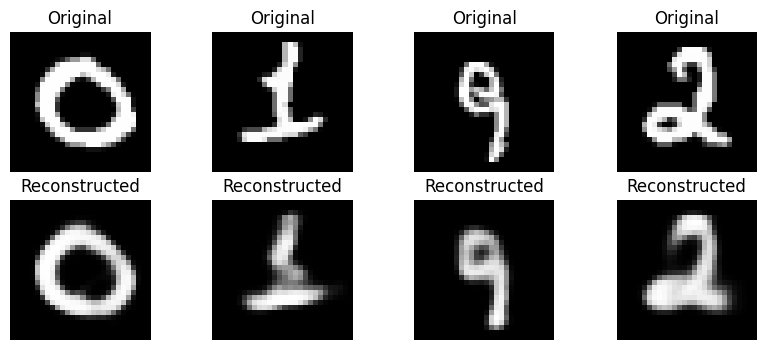

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.9667
Epoch 58: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.5058


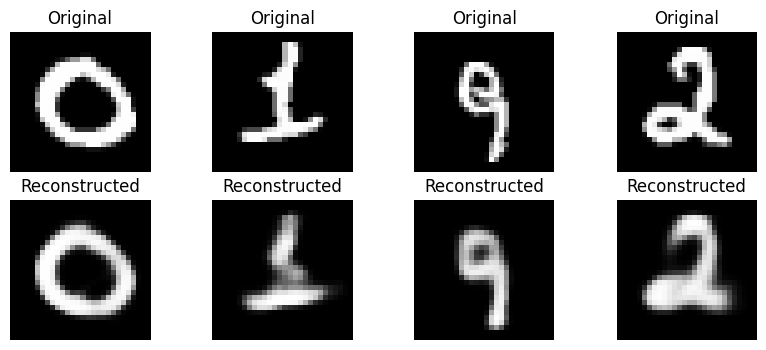

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.7944
Epoch 59: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.3998


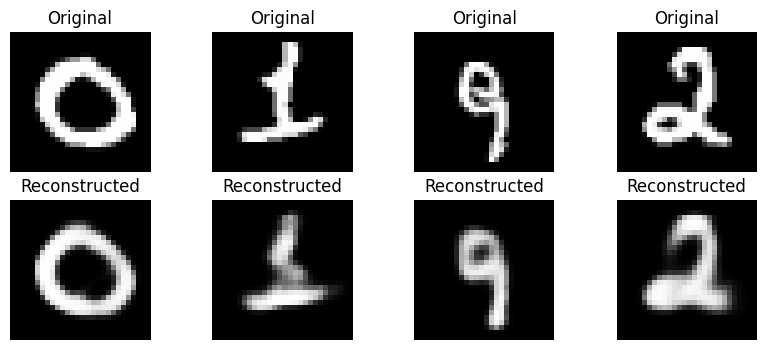

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.7169
Epoch 60: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.2918


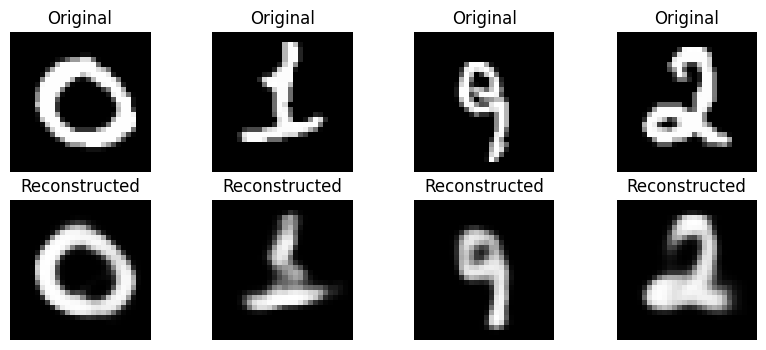

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.6524
Epoch 61: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.1868


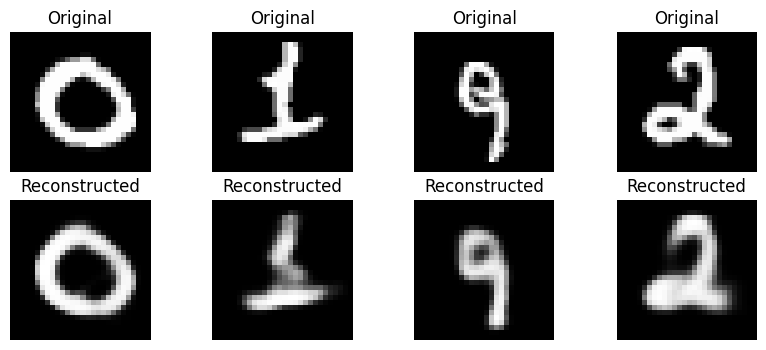

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.5063


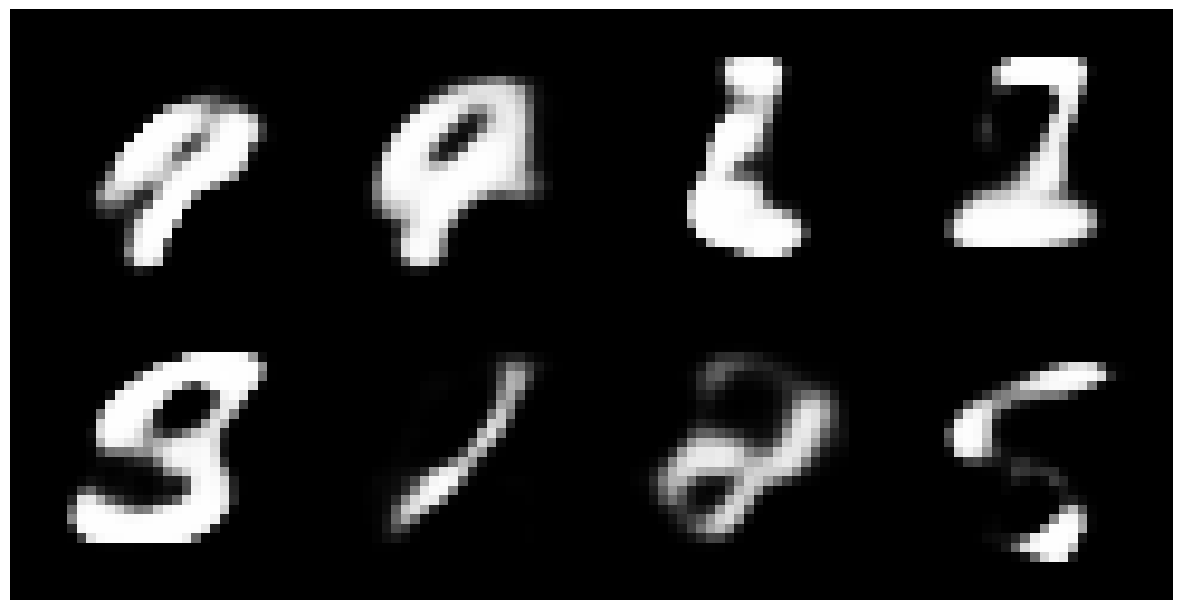

Epoch 62: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 90.0898


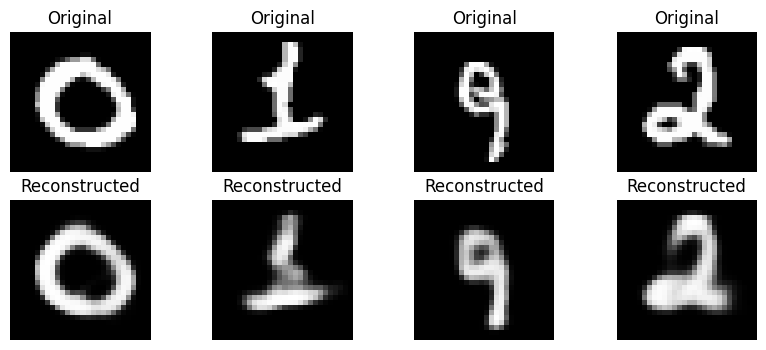

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.4155
Epoch 63: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.9849


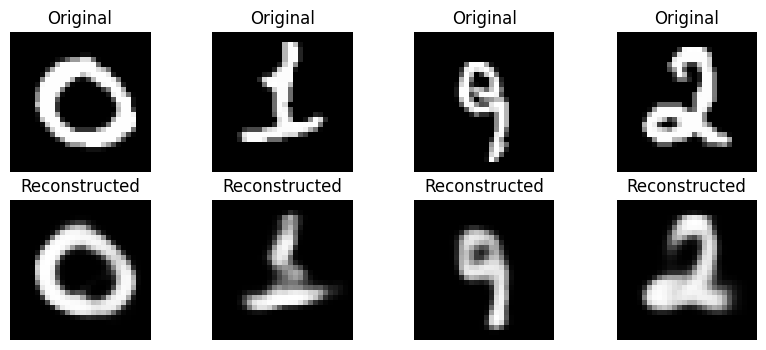

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.3523
Epoch 64: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.8849


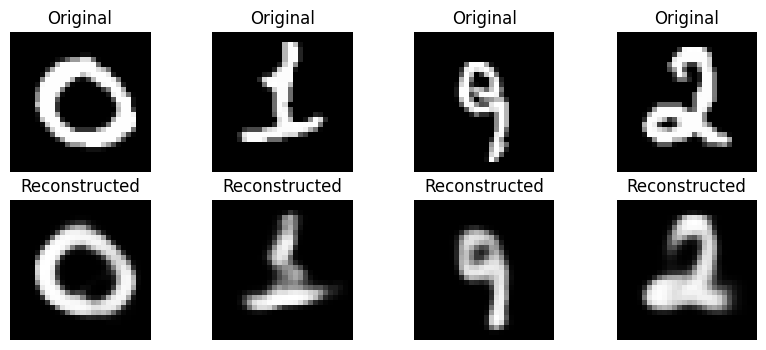

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.2511
Epoch 65: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.7921


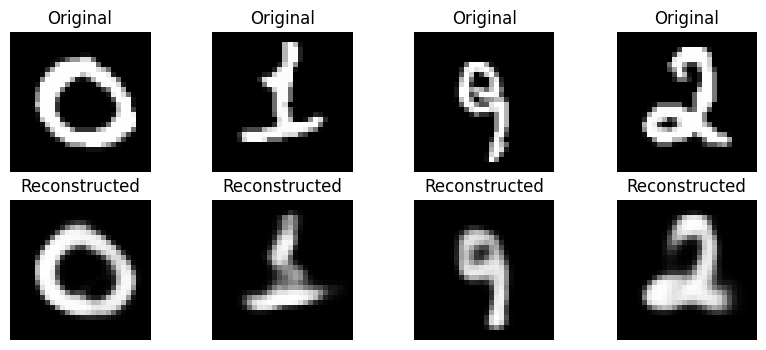

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.1784
Epoch 66: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.6967


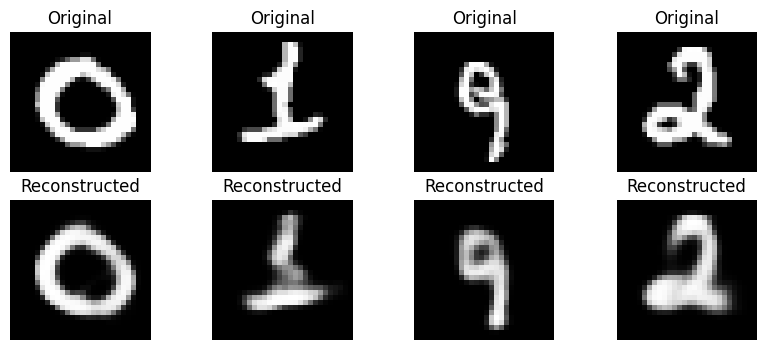

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.1375
Epoch 67: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.6030


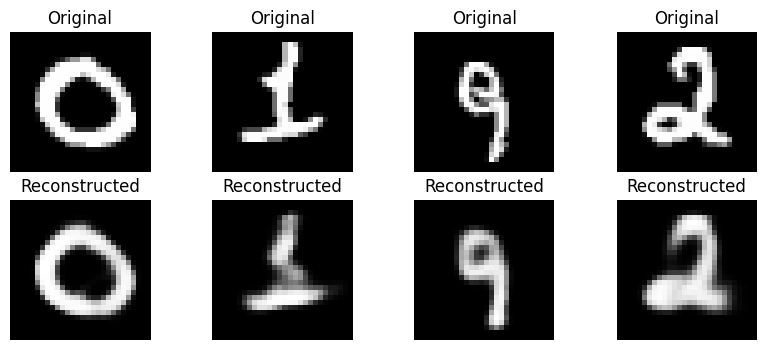

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.0013
Epoch 68: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.5193


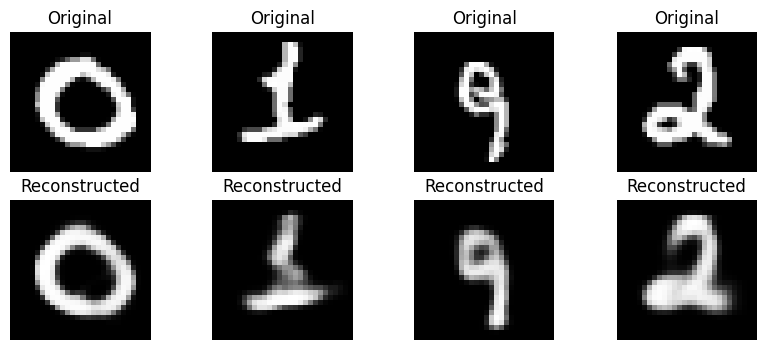

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 91.0312
Epoch 69: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.4164


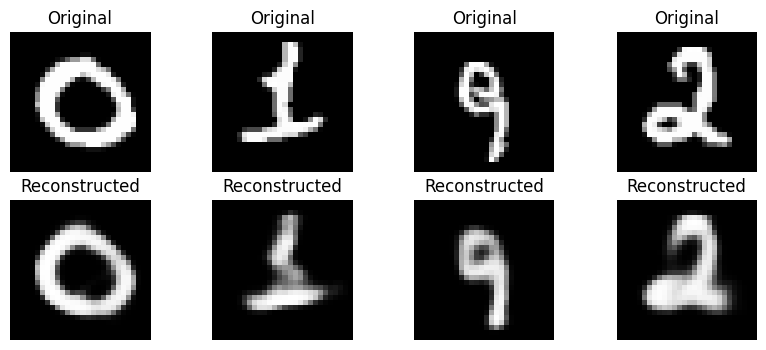

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.8886
Epoch 70: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.3330


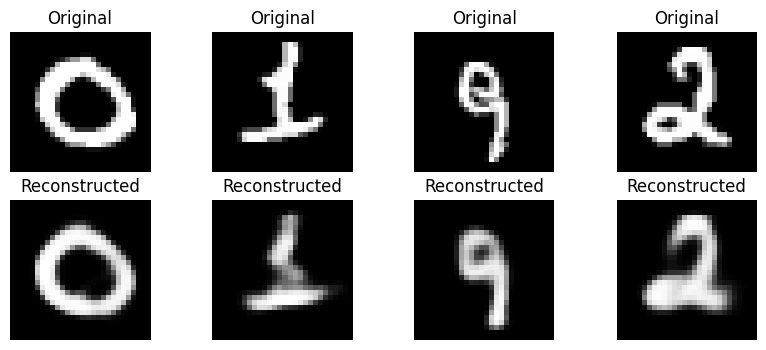

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.8116
Epoch 71: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.2496


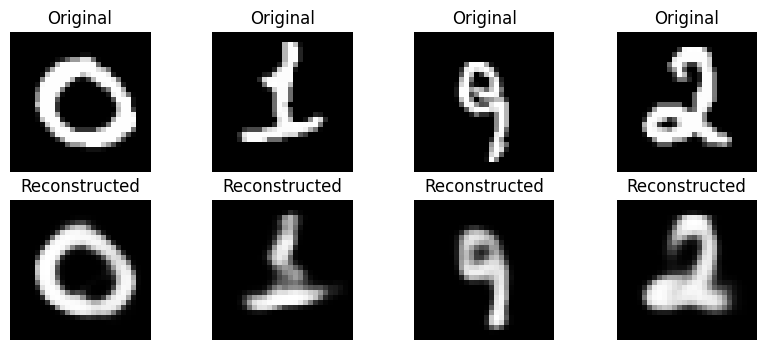

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.7580


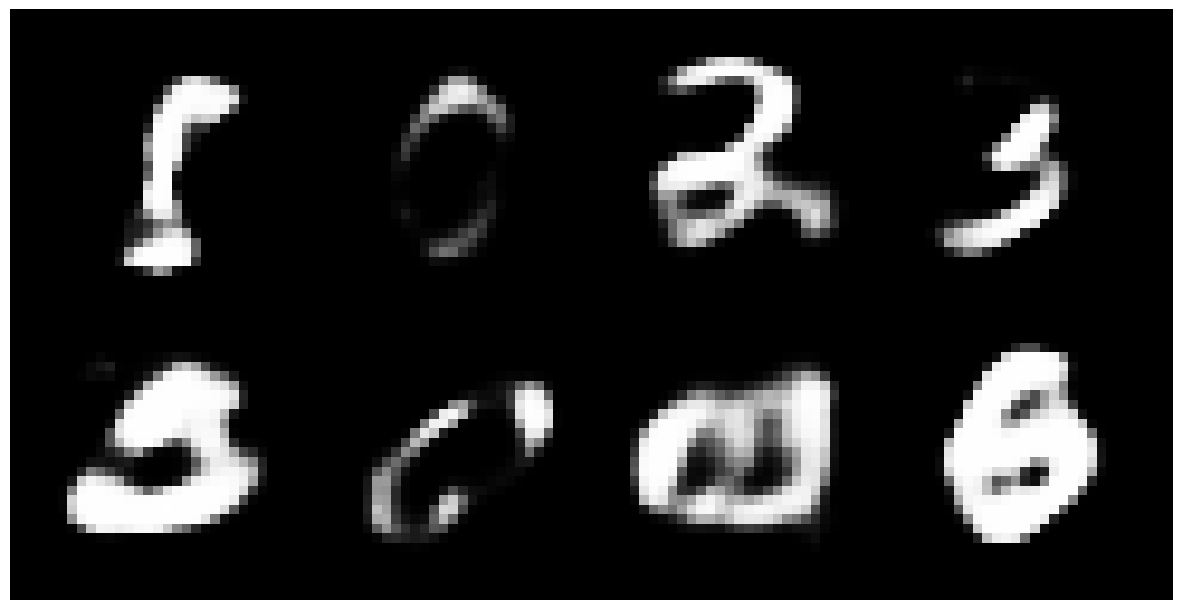

Epoch 72: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.1646


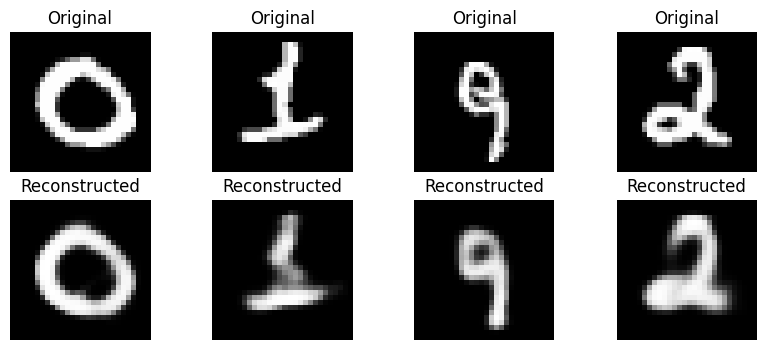

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.6549
Epoch 73: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 89.0828


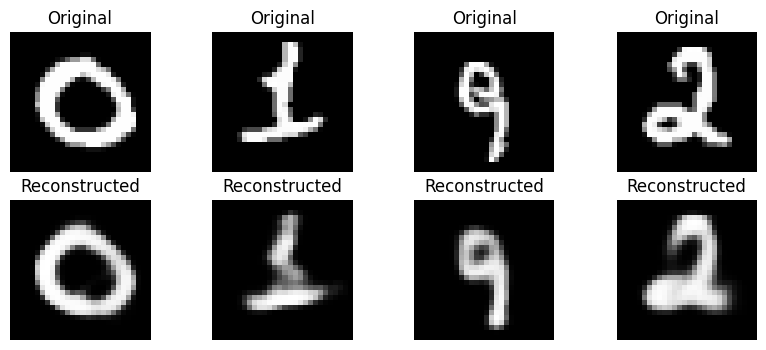

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.5248
Epoch 74: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.9983


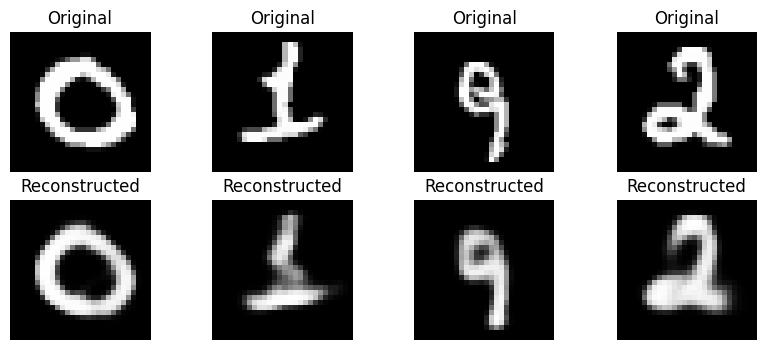

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.5052
Epoch 75: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.9254


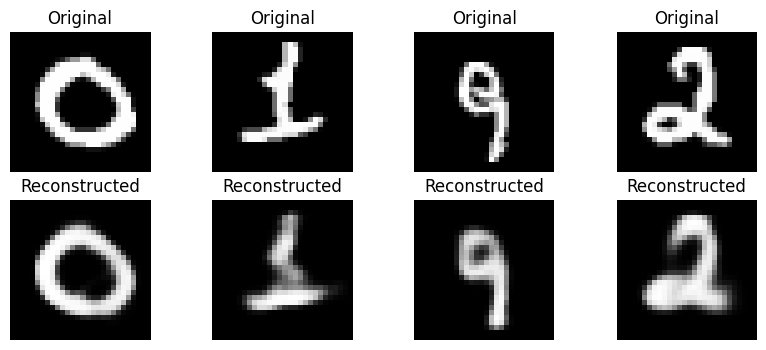

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.4522
Epoch 76: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.8391


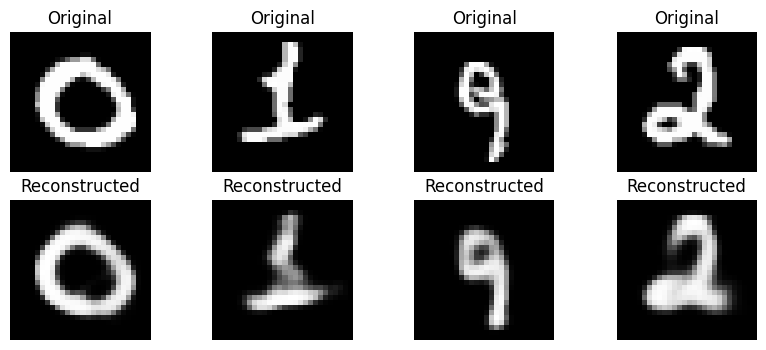

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.3356
Epoch 77: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.7630


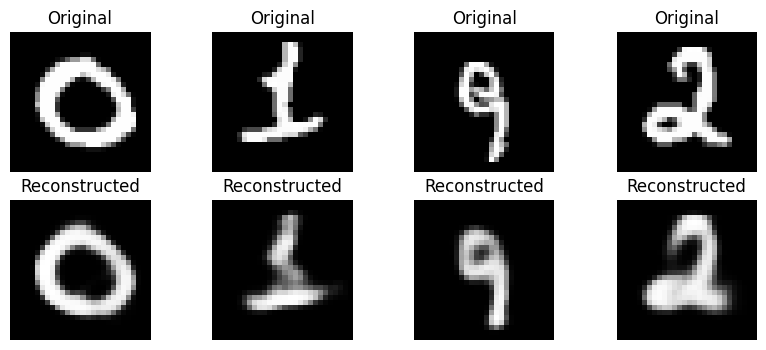

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.2764
Epoch 78: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.6925


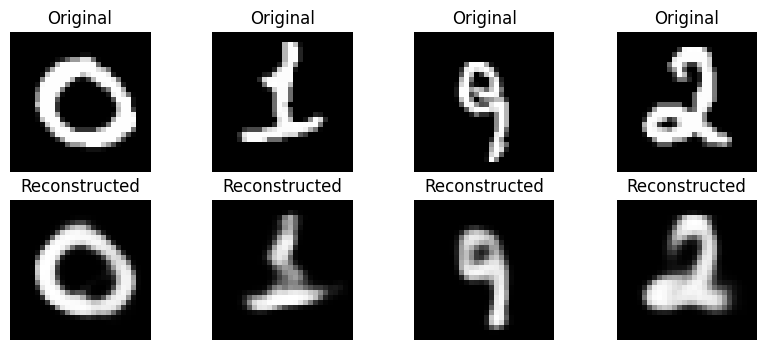

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.2200
Epoch 79: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.6132


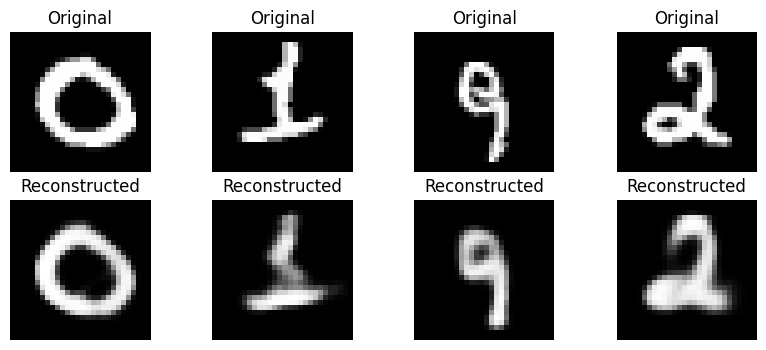

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.1630
Epoch 80: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.5433


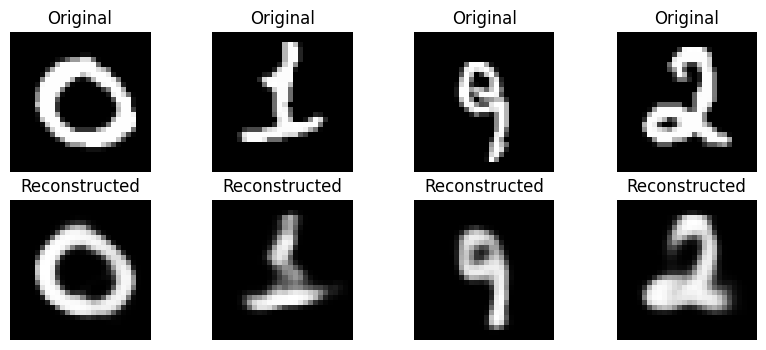

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.1685
Epoch 81: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.4751


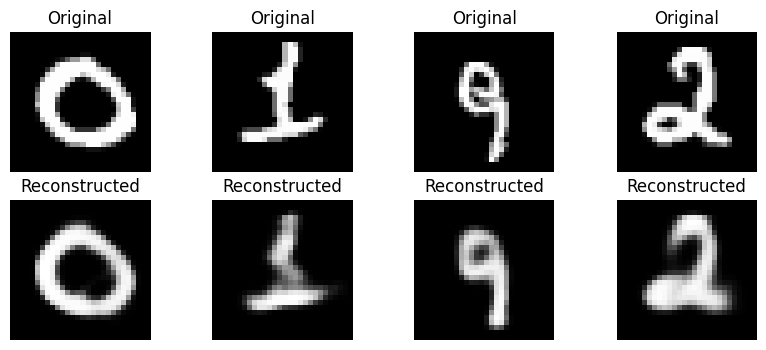

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.0593


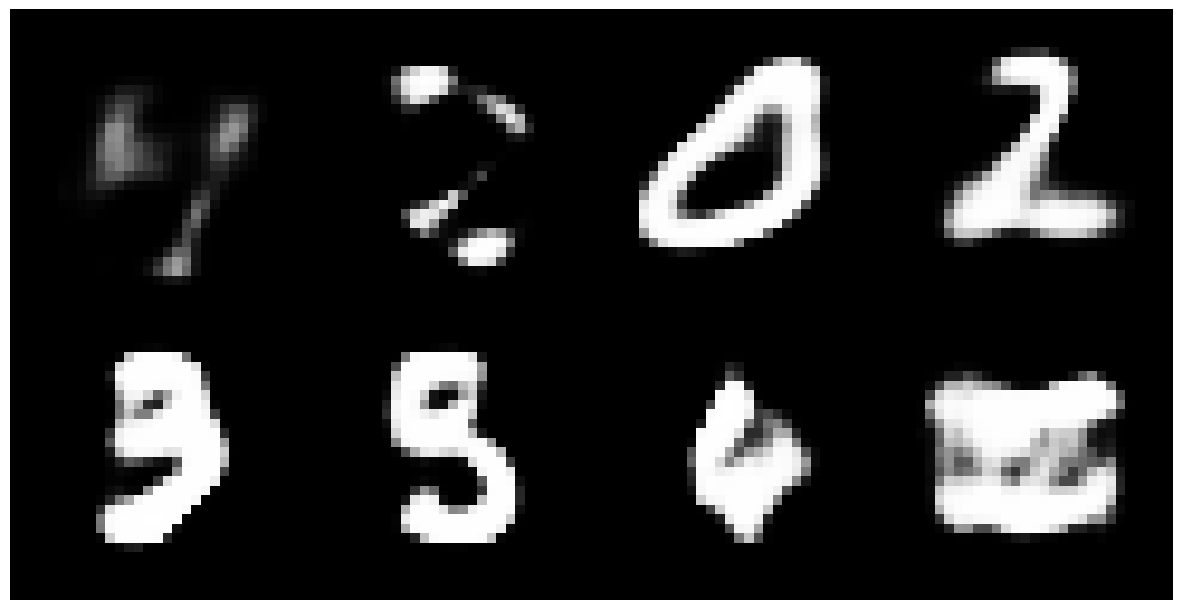

Epoch 82: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.3970


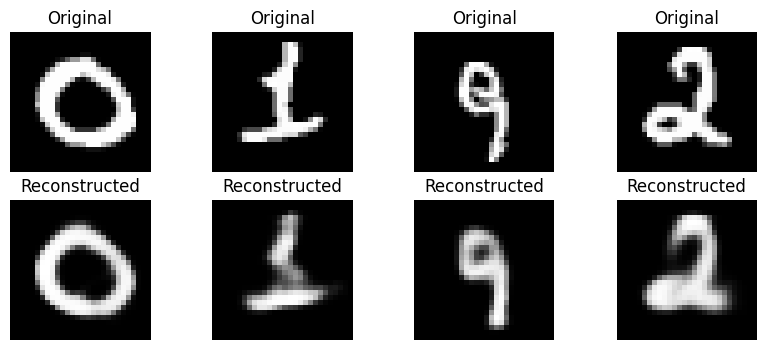

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 90.0690
Epoch 83: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.3276


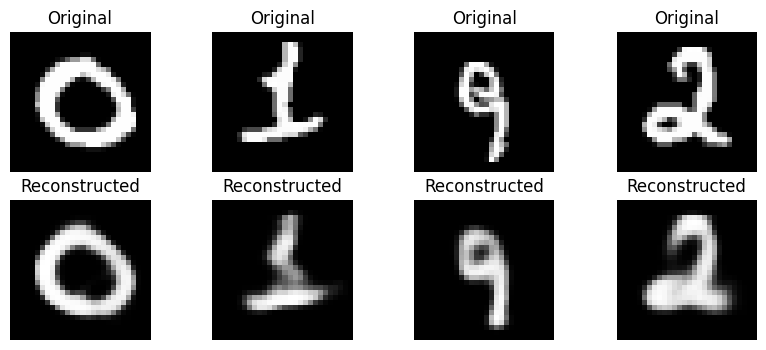

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.9285
Epoch 84: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.2645


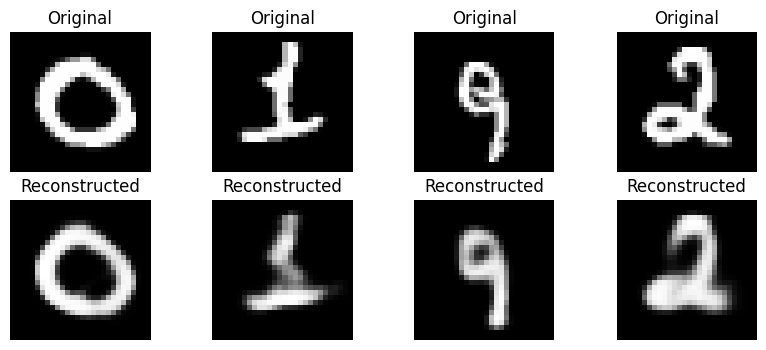

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.8727
Epoch 85: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.1968


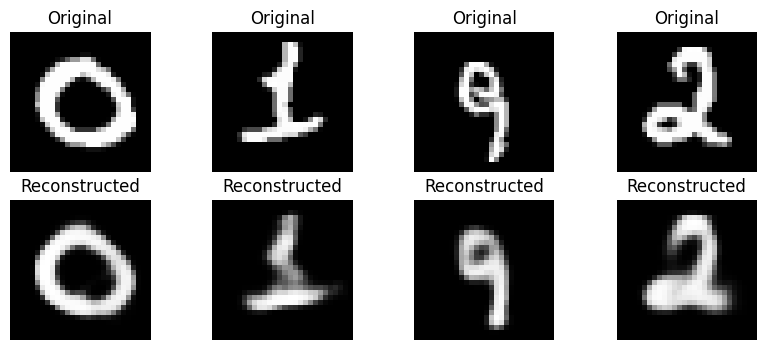

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.8011
Epoch 86: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.1219


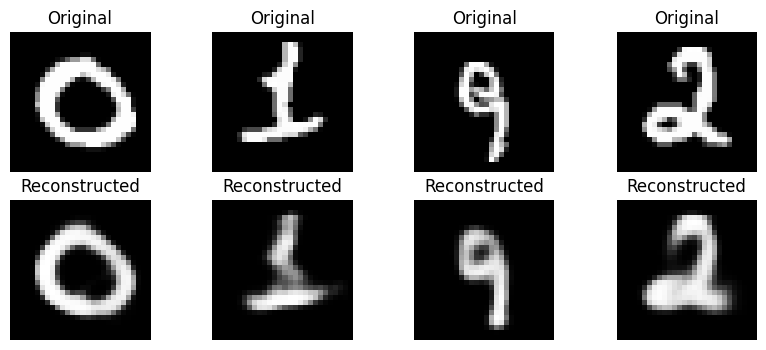

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.8029
Epoch 87: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 88.0617


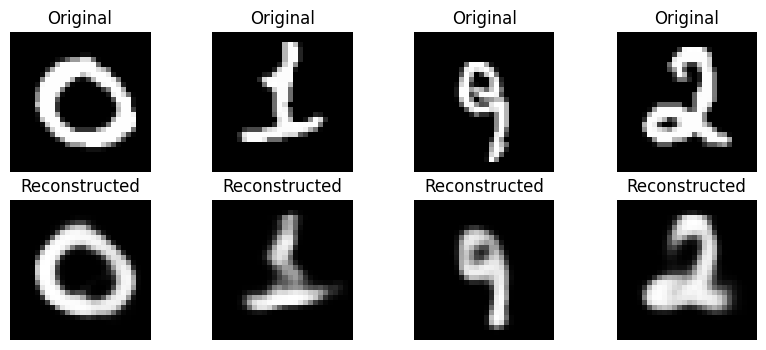

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.6971
Epoch 88: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.9898


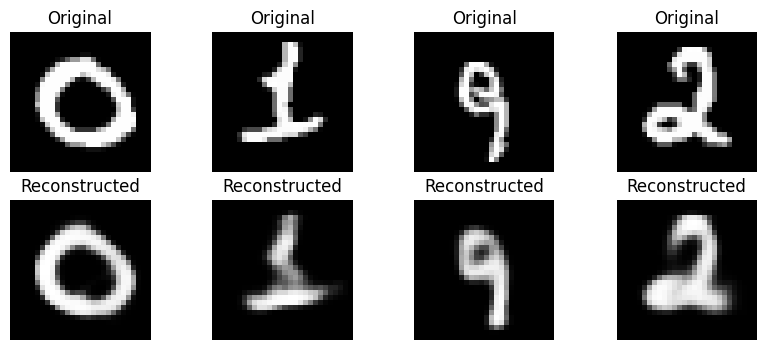

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.6123
Epoch 89: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.9320


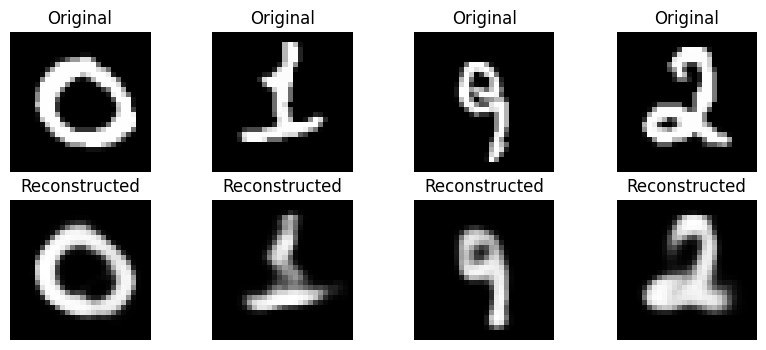

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.6144
Epoch 90: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.8721


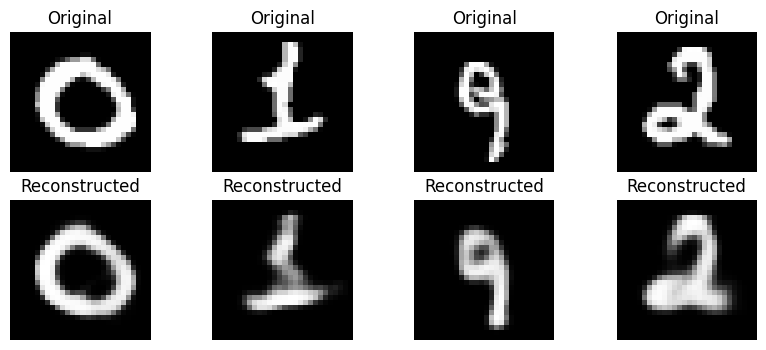

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.5032
Epoch 91: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.8053


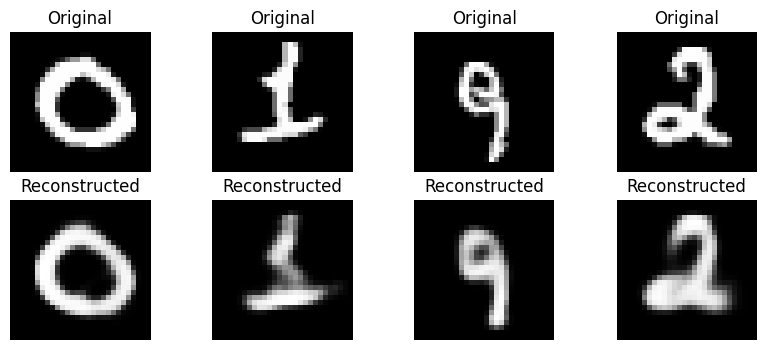

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.4981


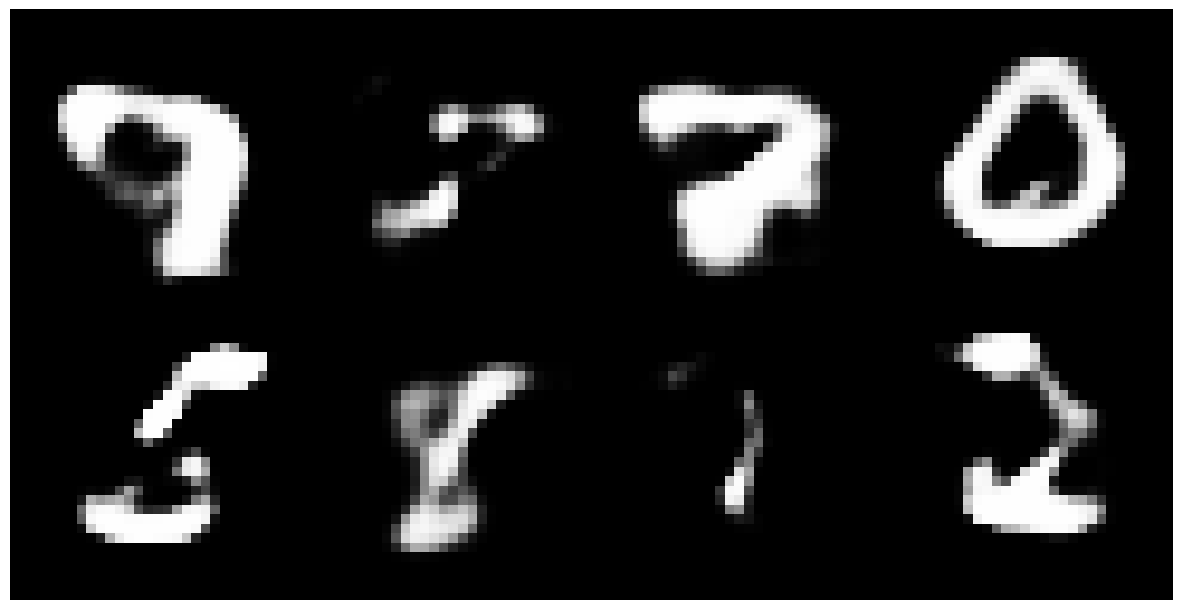

Epoch 92: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.7460


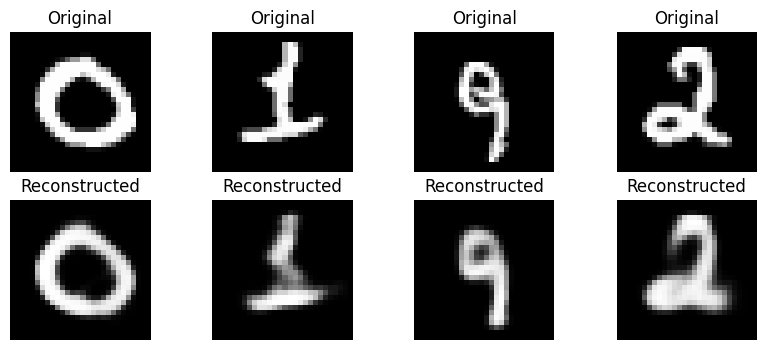

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.4729
Epoch 93: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.6864


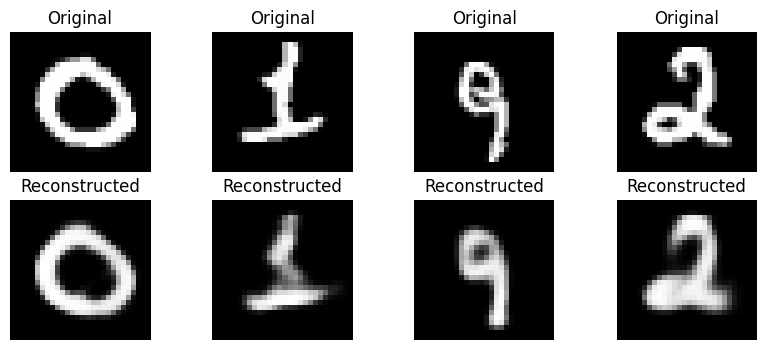

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.3145
Epoch 94: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.6294


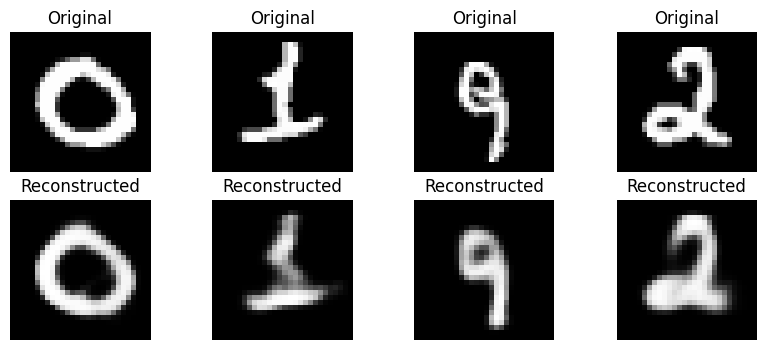

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.3670
Epoch 95: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.5749


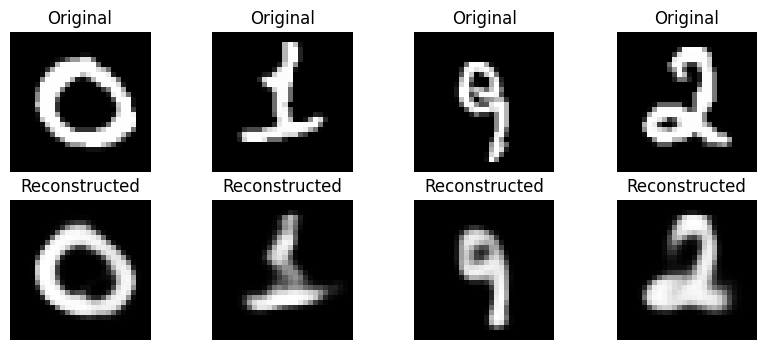

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.2536
Epoch 96: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.5165


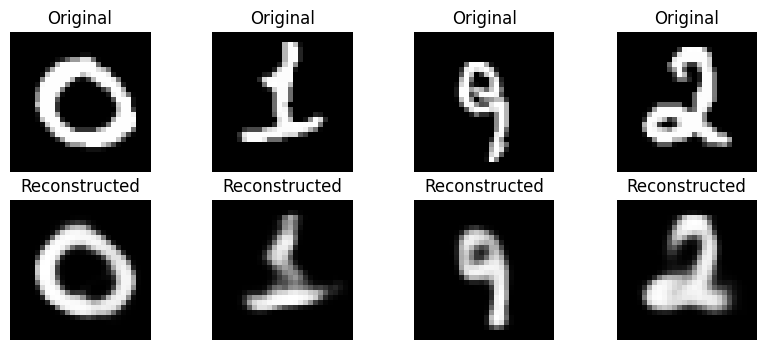

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.2161
Epoch 97: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.4568


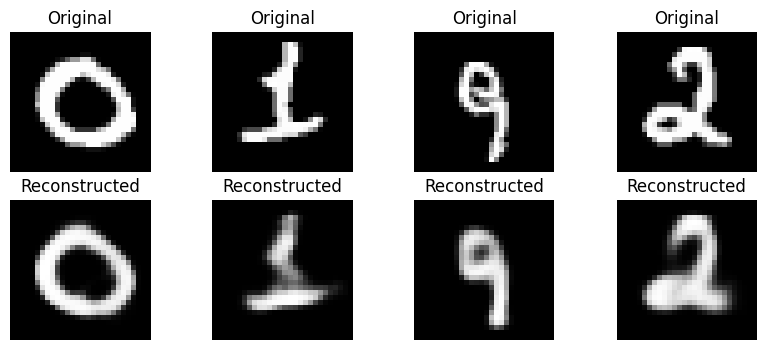

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.1875
Epoch 98: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.3989


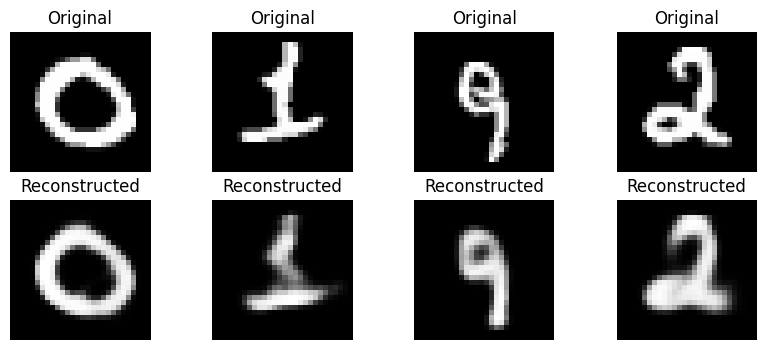

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.1137
Epoch 99: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.3488


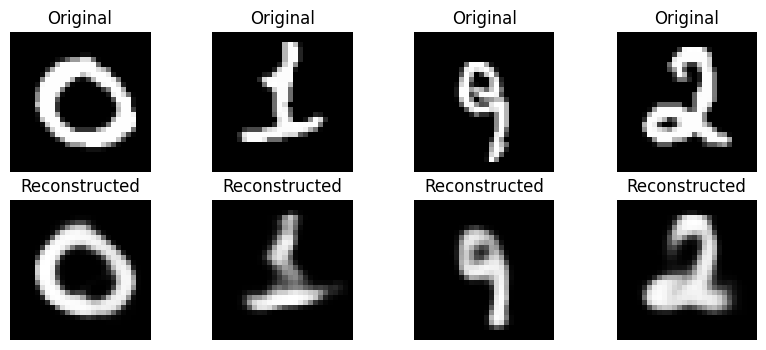

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 89.0841
Epoch 100: 


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 87.2927


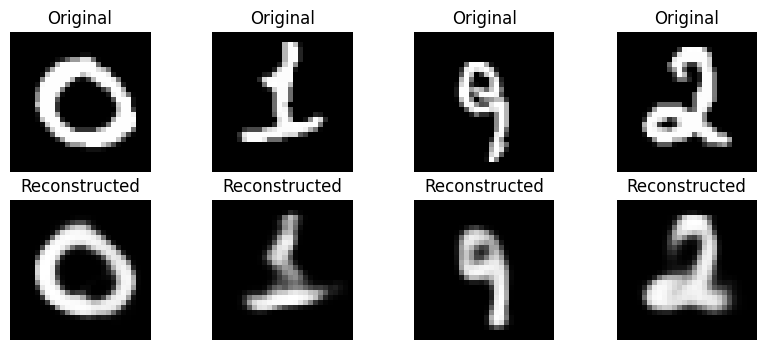

  0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 88.9942


In [ ]:
input_dim = 784
hidden_dim = 256
latent_dim = 10
model, vae_val_loss = train_vae(train_loader, val_loader, latent_dim, hidden_dim, input_dim, num_epochs=100)

In [ ]:
torch.save(model.state_dict(), data_path+'vae_model.pth')

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape

        self.model = nn.Sequential(
            # TODO
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64 * 7 * 7),
            nn.BatchNorm1d(64 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample from (64, 7, 7) to (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Upsample from (32, 14, 14) to (16, 28, 28)
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),  # Keep (16, 28, 28) to (1, 28, 28)
            nn.Tanh(),
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)

        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.model = nn.Sequential(
            # TODO
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        img_flat = img.view(img.size(0), 1, 28, 28)
        x = self.model(img_flat)

        return x

In [ ]:
def train_gan(dataloader, val_loader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape)
    discriminator = Discriminator(img_shape)
    adversarial_loss = nn.BCELoss() # TODO
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate) # TODO
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate) # TODO

    val_gen_losses, val_dis_losses = [], []
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################
                z = torch.randn(imgs.shape[0], latent_dim)
                z = z.type_as(imgs)

                # valid and fake labels
                valid = torch.ones(imgs.size(0), 1).type_as(imgs)
                fake = torch.zeros(imgs.size(0), 1).type_as(imgs)

                # Train Generator# Sample noise as generator input
                optimizer_G.zero_grad()
                generated_imgs = generator(z)
                g_loss = adversarial_loss(discriminator(generated_imgs), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = adversarial_loss(discriminator(imgs), valid)
                fake_loss = adversarial_loss(discriminator(generator(z).detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()

                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch
        generator.eval()
        discriminator.eval()
        val_loss = [0., 0.]
        with torch.no_grad():
          with tqdm(enumerate(val_loader), total=len(val_loader)) as vbar:
              for i, (imgs, _) in vbar:

                  ##########################################################
                  # TODO
                  # Calculate the loss for the Generator and the Discriminator.
                  ##########################################################
                  z = torch.randn(imgs.shape[0], latent_dim)
                  z = z.type_as(imgs)

                  # valid and fake labels
                  valid = torch.ones(imgs.size(0), 1).type_as(imgs)
                  fake = torch.zeros(imgs.size(0), 1).type_as(imgs)

                  # Train Generator# Sample noise as generator input
                  generated_imgs = generator(z)
                  g_loss = adversarial_loss(discriminator(generated_imgs), valid)

                  # Train Discriminator
                  real_loss = adversarial_loss(discriminator(imgs), valid)
                  fake_loss = adversarial_loss(discriminator(generator(z).detach()), fake)
                  d_loss = (real_loss + fake_loss) / 2

                  # TODO
                  # Calculate and fill discriminator and generator losses
                  vbar.set_description("[Validation] [D loss: {:.4f}] [G loss: {:.4f}]".format(d_loss.item(), g_loss.item()))
                  val_loss[0] = val_loss[0] + g_loss
                  val_loss[1] = val_loss[1] + d_loss

              val_gen_losses.append(val_loss[0] / len(val_loader))
              val_dis_losses.append(val_loss[1] / len(val_loader))
              print("[Validation avg loss] ----- [D loss: {:.4f}] [G loss: {:.4f}]".format(val_dis_losses[-1], val_gen_losses[-1]))

        z = torch.randn(8, latent_dim).type_as(imgs)
        generated_imgs = generator(z)
        grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.show()

    return generator, discriminator, val_gen_losses, val_dis_losses

In [ ]:
latent_dim = 100

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4094] [G loss: 2.5107]


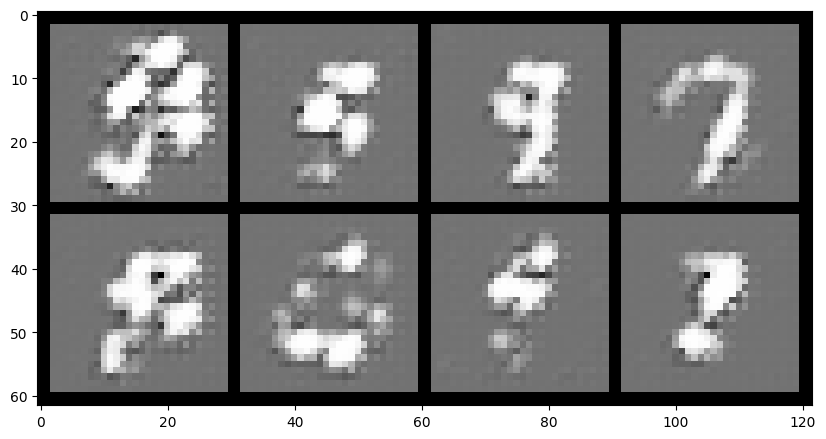

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.3538] [G loss: 2.7803]


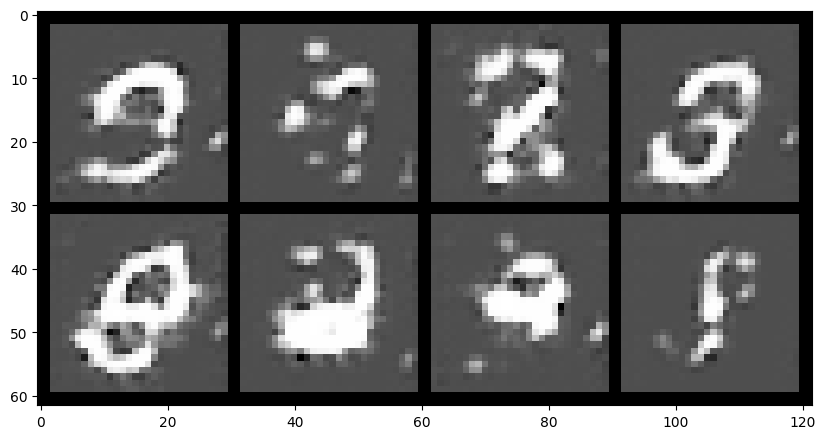

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.2753] [G loss: 2.9763]


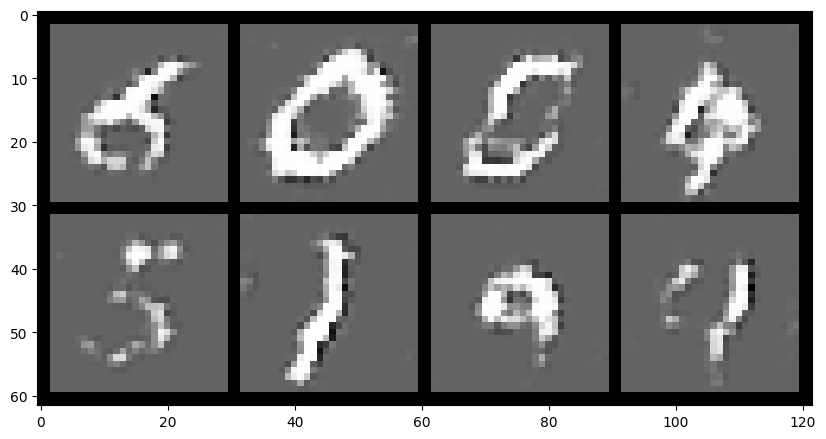

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.2679] [G loss: 2.0216]


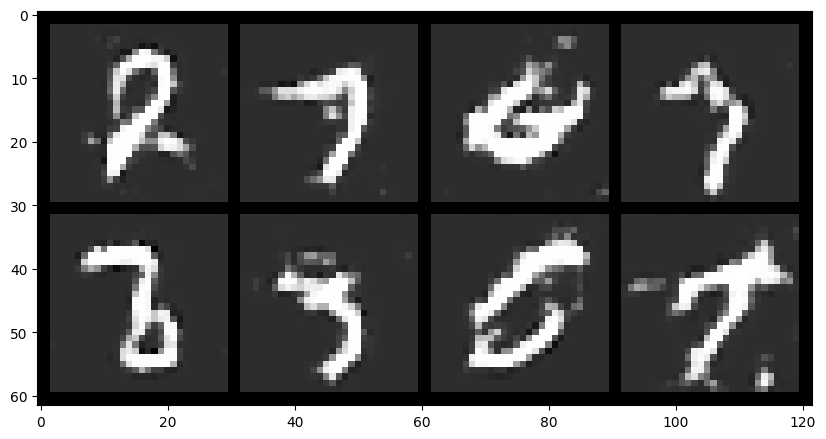

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5500] [G loss: 1.0177]


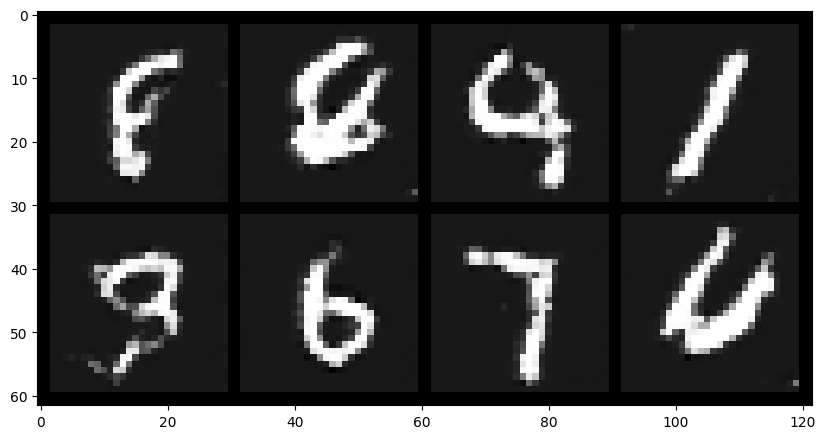

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5013] [G loss: 2.2175]


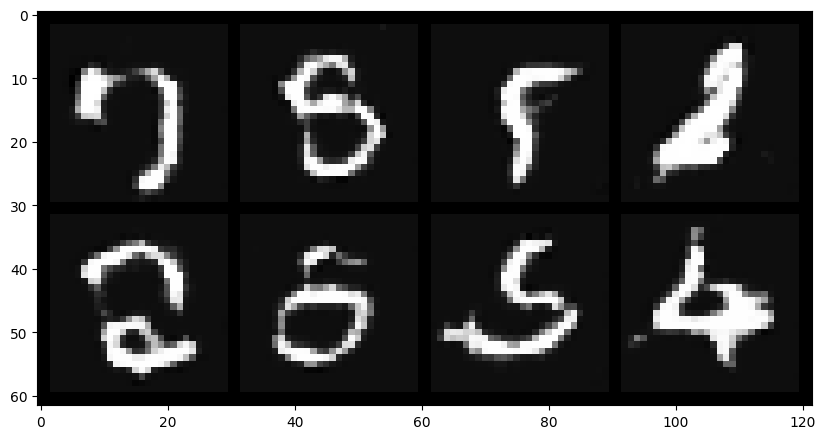

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4632] [G loss: 1.5781]


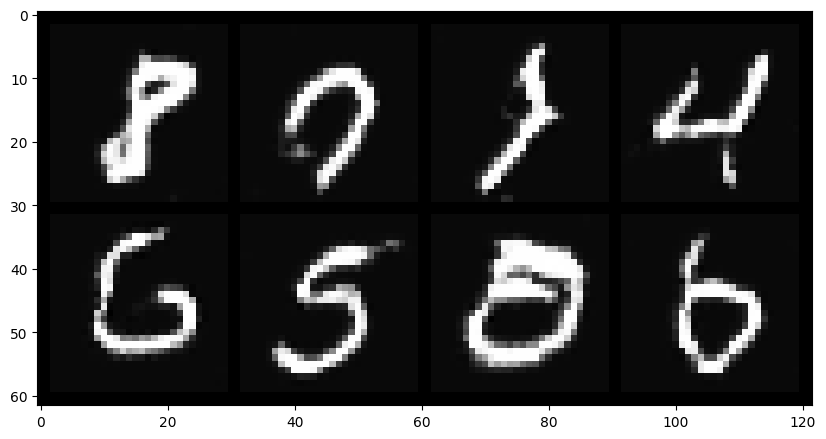

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5171] [G loss: 1.1678]


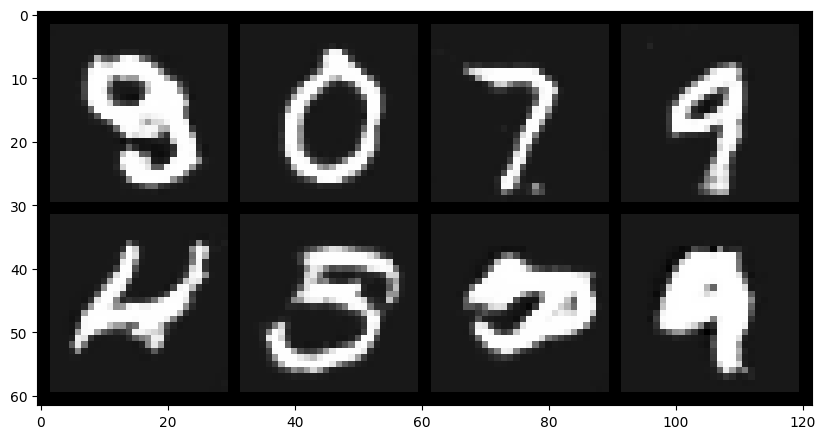

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4983] [G loss: 1.7978]


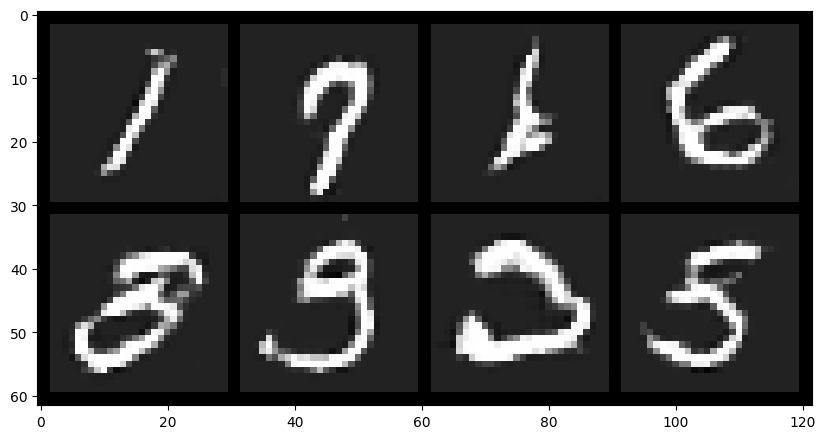

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5503] [G loss: 2.1785]


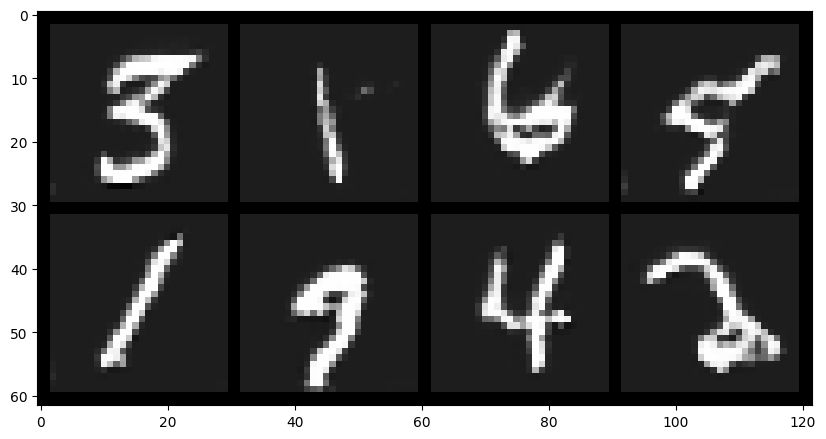

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4688] [G loss: 1.5536]


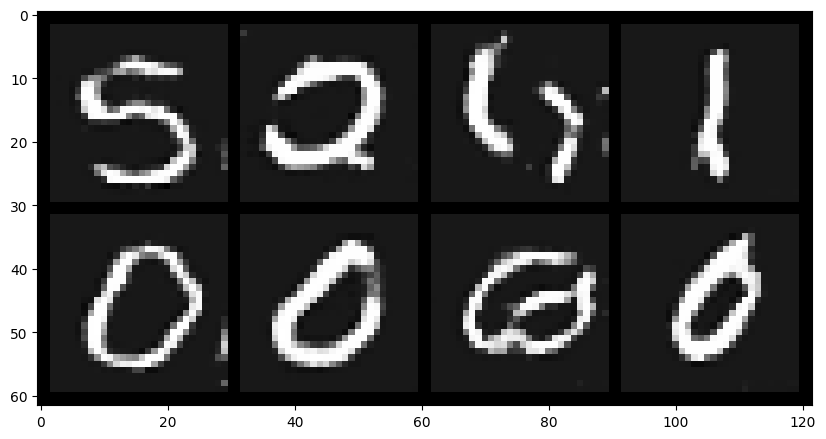

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5160] [G loss: 1.4150]


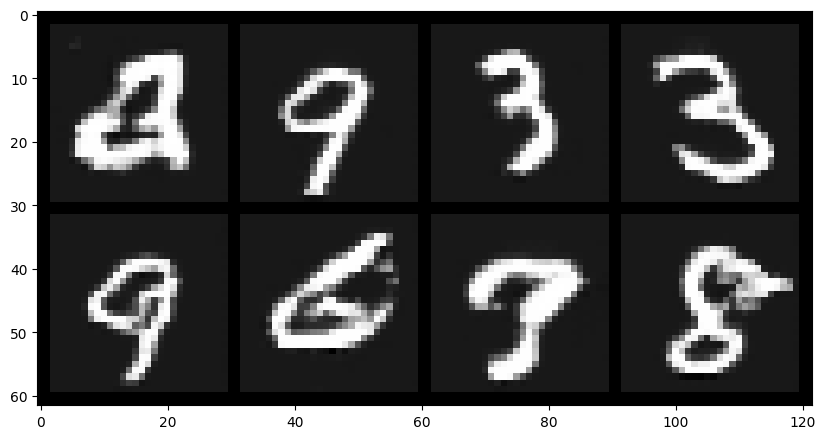

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6038] [G loss: 1.7555]


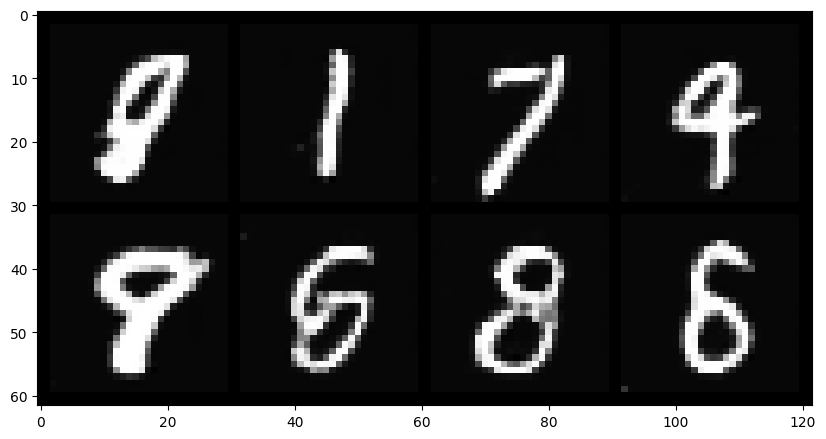

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5541] [G loss: 1.5367]


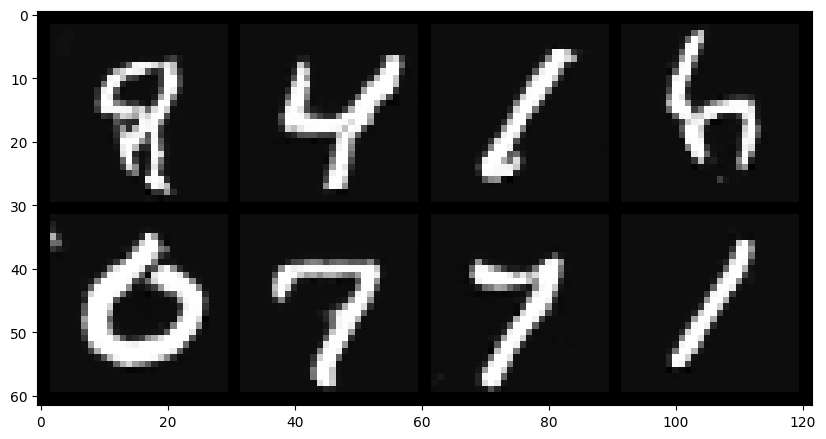

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5499] [G loss: 0.8987]


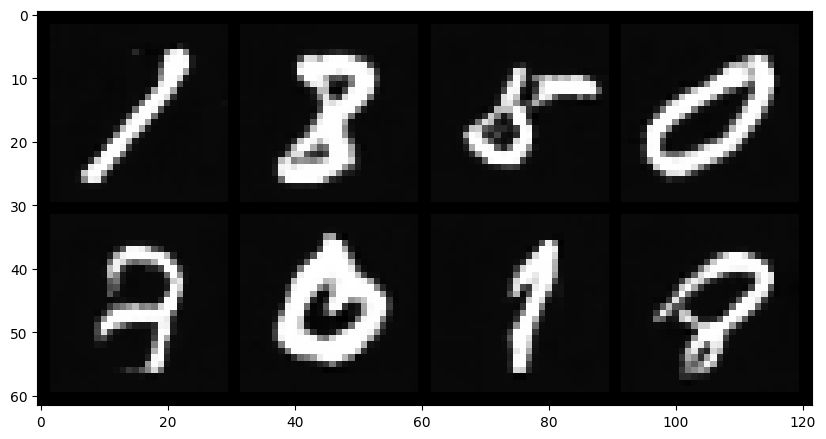

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5315] [G loss: 1.3108]


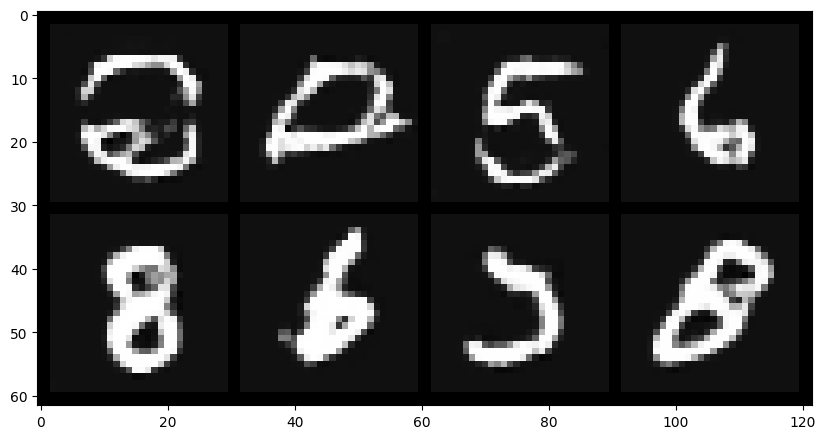

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6056] [G loss: 1.1923]


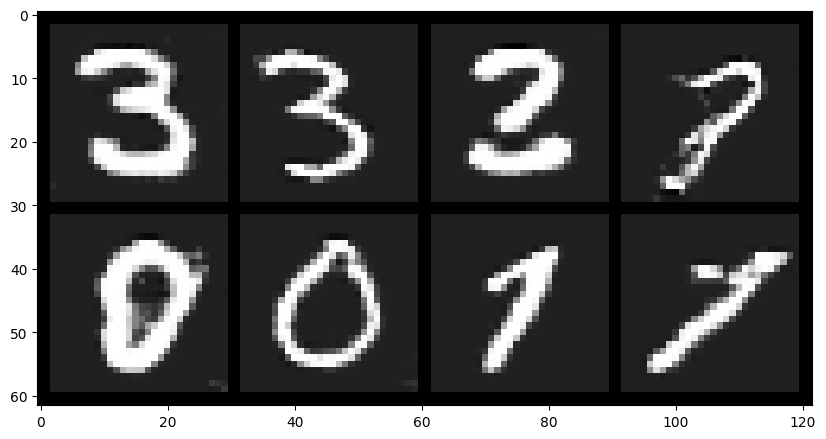

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5322] [G loss: 1.3468]


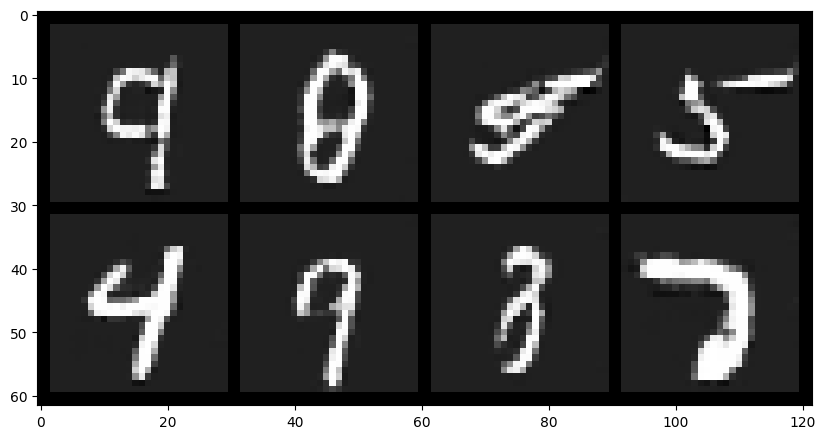

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5642] [G loss: 1.1607]


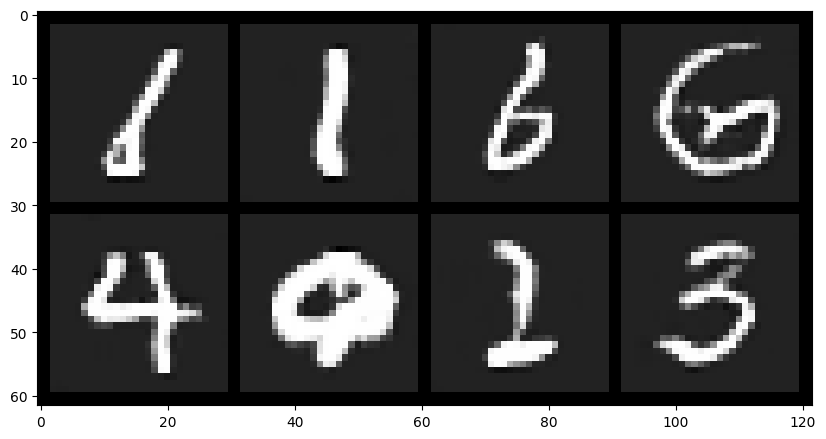

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5687] [G loss: 1.1410]


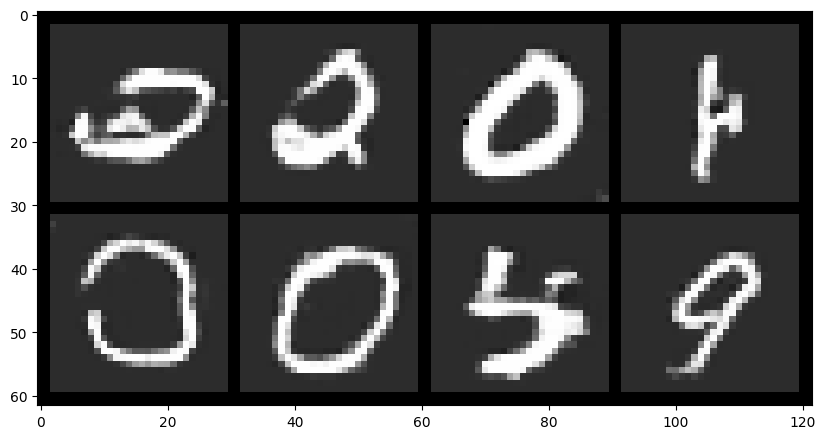

In [ ]:
generator, discriminator, val_gen_losses, val_dis_losses = train_gan(train_loader, val_loader, latent_dim, num_epochs=20)

In [ ]:
torch.save(generator.state_dict(), data_path+'gen_model.pth')
torch.save(discriminator.state_dict(), data_path+'dis_model.pth')

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [ ]:
# TODO
# Comparison of the generated images

In [10]:
def plot(losses, title):
  plt.plot(np.arange(len(losses)), losses)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title)
  plt.show()

## **VAE**

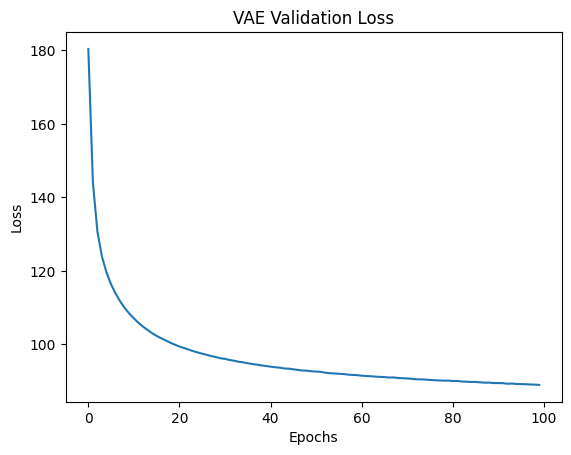

In [ ]:
# VAE validation loss plot
plot(losses=vae_val_loss, title='VAE Validation Loss')

In [15]:
vae = VAE(784, 256, 10)
vae.load_state_dict(torch.load(data_path+'vae_model.pth'))
vae.eval()

VAE(
  (encoder): Encoder(
    (linear): Linear(in_features=784, out_features=256, bias=True)
    (linear_mean): Linear(in_features=256, out_features=10, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=10, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [11]:
def VAElatentSamplegeneration(model, num=64):
  model.eval()
  with torch.no_grad():
    x = torch.randn(num, 10).to(DEVICE)
    samples = model.decoder(x).cpu()
    samples = samples.view(num, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(samples, nrow=num//8, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

  return samples

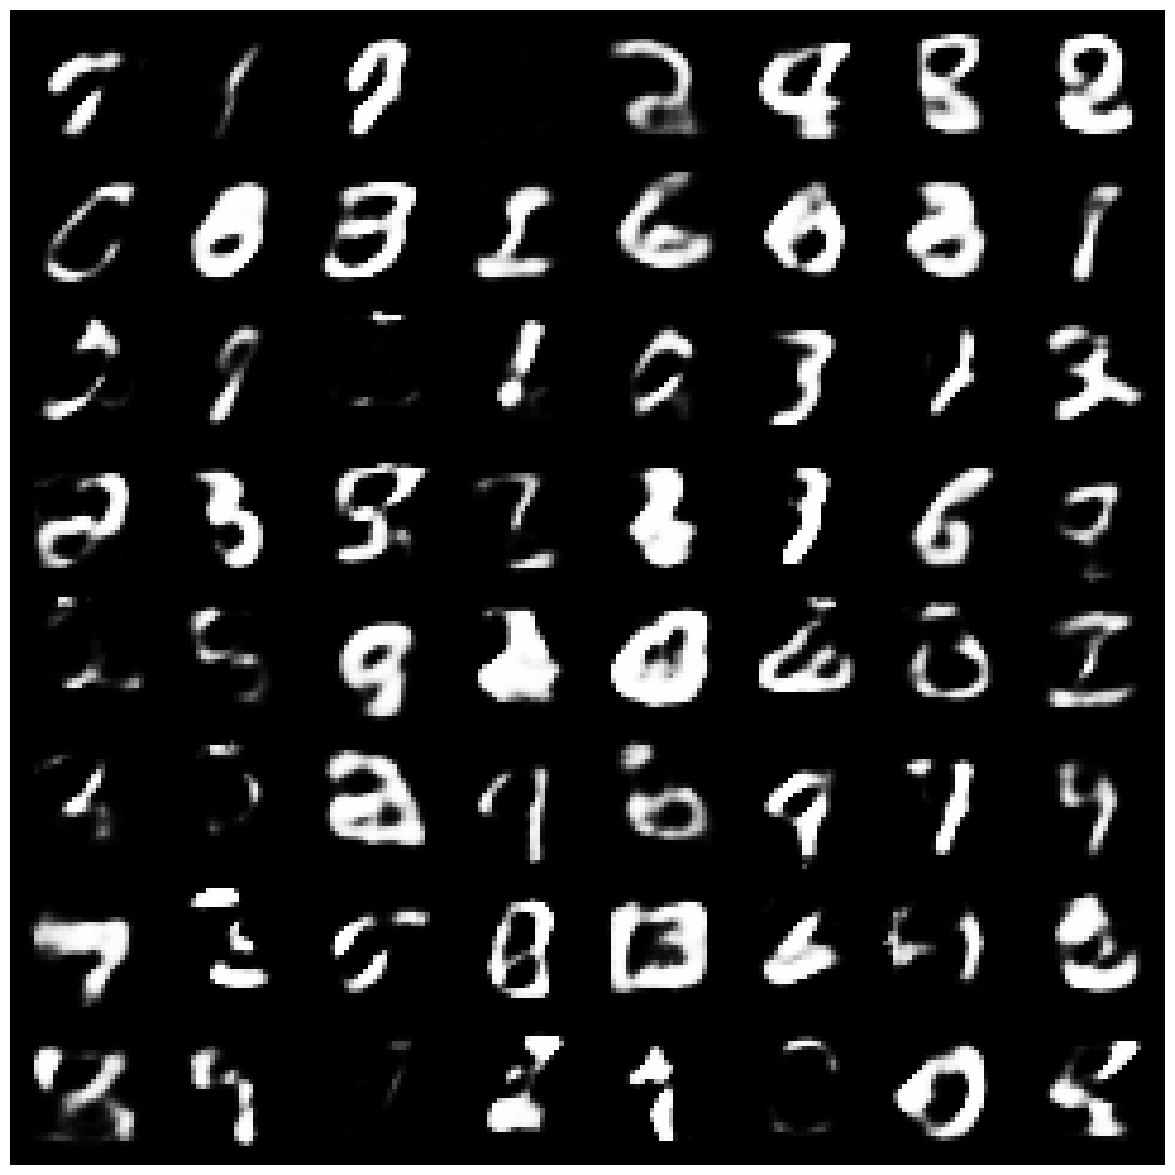

In [ ]:
VAElatentSamplegeneration(vae)

## **GAN**

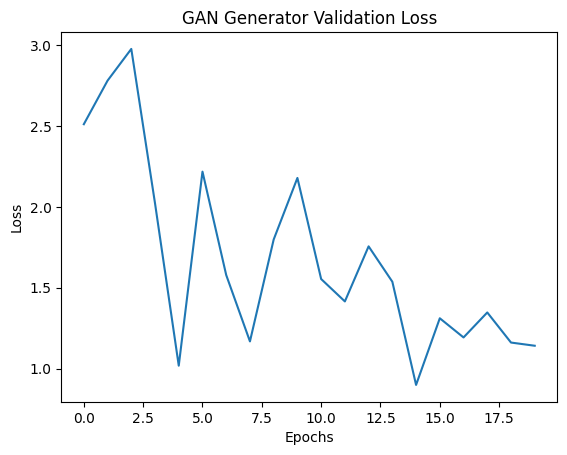

In [ ]:
# GAN Generator validation loss plot
plot(losses=val_gen_losses, title='GAN Generator Validation Loss')

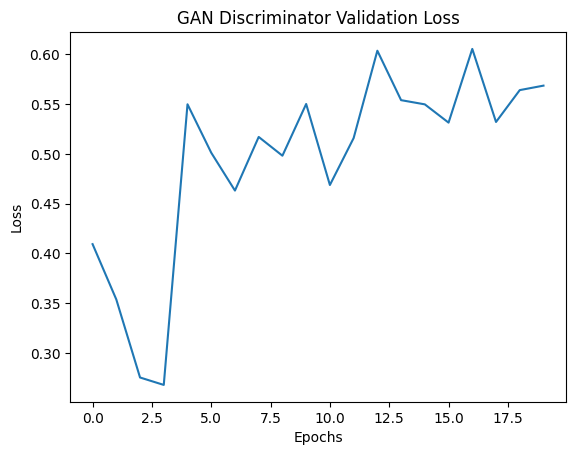

In [ ]:
# GAN Discriminator validation loss plot
plot(losses=val_dis_losses, title='GAN Discriminator Validation Loss')

In [13]:
generator = Generator(latent_dim=100, img_shape=(1, 28, 28))
generator.load_state_dict(torch.load(data_path+'gen_model.pth'))
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=3136, bias=True)
    (4): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Tanh()
  )
)

In [12]:
def GANlatentSamplegeneration(model, num=64):
  model.eval()
  with torch.no_grad():
    x = torch.randn(num, 100).to(DEVICE)
    samples = model(x).cpu()
    samples = samples.view(num, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(samples, nrow=num//8, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

  return samples

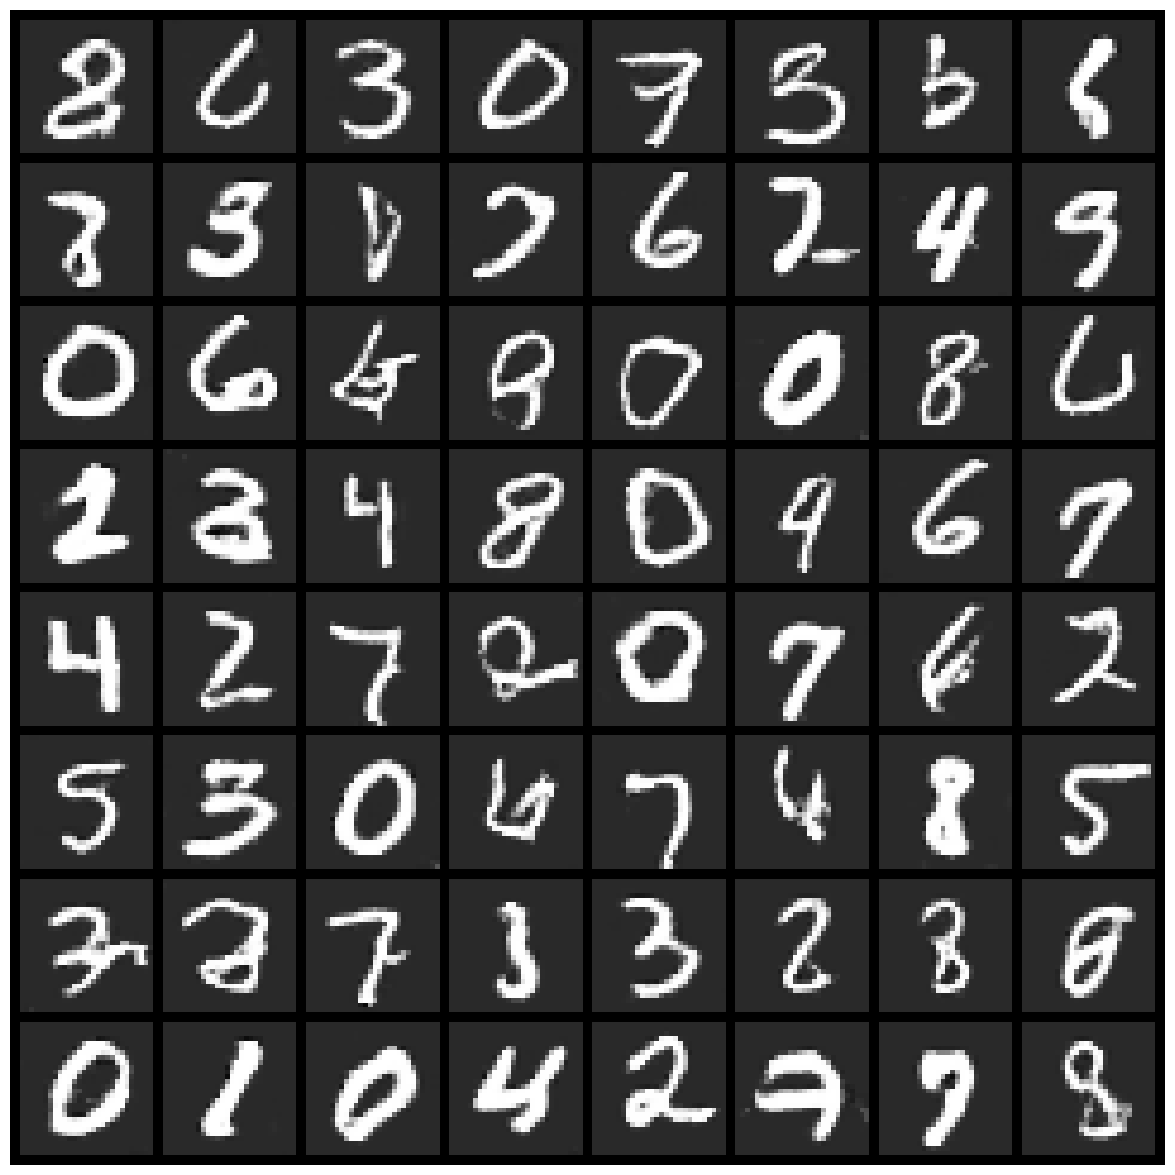

In [ ]:
GANlatentSamplegeneration(generator, num=64)

## Evaluate with GAN discriminator

In [19]:
# load discriminator
discriminator = Discriminator(img_dim=(1, 28, 28))
discriminator.load_state_dict(torch.load(data_path+'dis_model.pth'))

<All keys matched successfully>

In [29]:
def discriminatorEvaluation(model, generated_samples):
  model.eval()
  pred_validation = model(generated_samples)

  pred_validation[pred_validation >= 0.5] = 1
  pred_validation[pred_validation < 0.5] = 0

  return np.count_nonzero(pred_validation == 1) / pred_validation.shape[0]

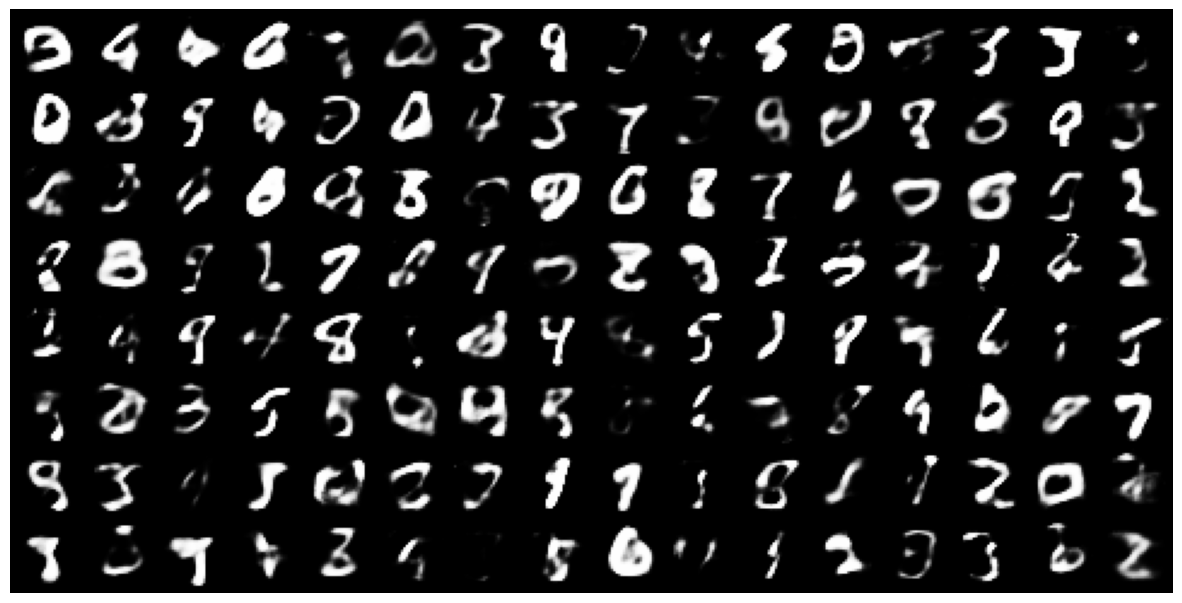

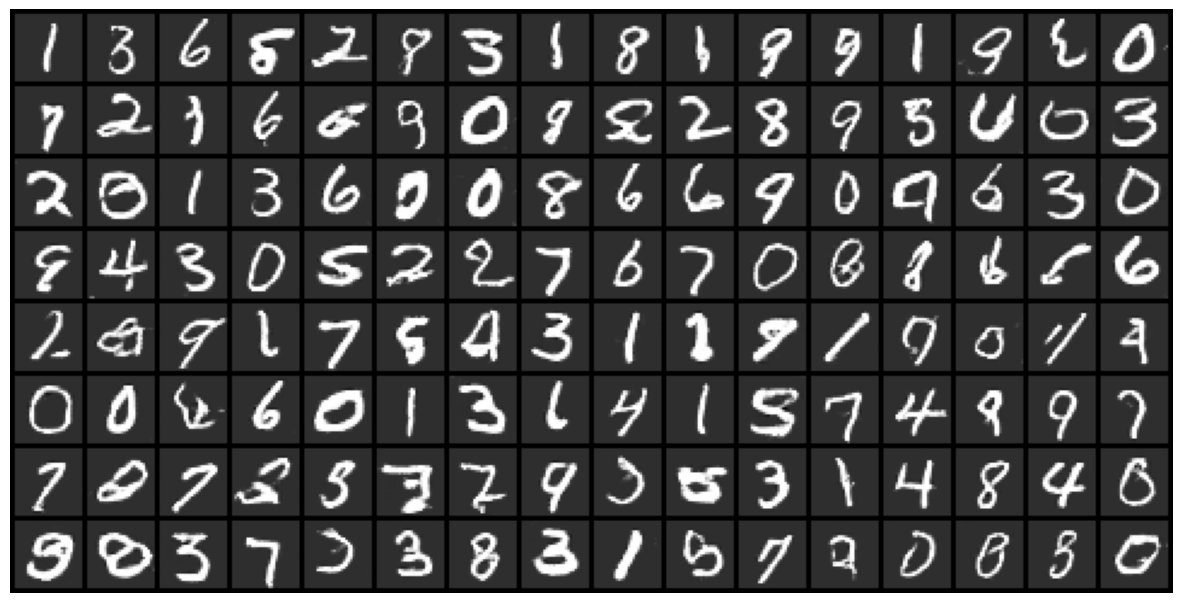

In [22]:
vae_generated_samples = VAElatentSamplegeneration(vae.to('cuda'), num=128)
gan_generated_samples = GANlatentSamplegeneration(generator.to('cuda'), num=128)

In [24]:
vae_generated_samples.shape, gan_generated_samples.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

In [33]:
print(f'percentage of valid generated image to all for GAN model: {discriminatorEvaluation(discriminator, gan_generated_samples)}')
print(f'percentage of valid generated image to all for VAE model: {discriminatorEvaluation(discriminator, vae_generated_samples)}')

percentage of valid generated image to all for GAN model: 0.2109375
percentage of valid generated image to all for VAE model: 0.2734375
